# Requirements to run this Notebook

In [4]:
#!pip3 install wn
#!pip3 install spacy
#!python -m spacy download de_core_news_md
#!pip3 install networkx
#!pip3 install tabulate

In [2]:
#!pip3 install -U numpy

In [1314]:
# requirements 
import pandas as pd
import numpy as np
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import networkx as nx
import ast
from ast import literal_eval
from tabulate import tabulate
#import seaborn as sns
#%matplotlib inline
import spacy
nlp = spacy.load('de_core_news_md')
from pathlib import Path


import wn
import wn.taxonomy
#wn.download('odenet')
#wn.download('oewn:2021')

en = wn.Wordnet('oewn:2021')
de = wn.Wordnet('odenet:1.4')

from wn.similarity import path

#from ast import literal_eval
#df['POS_tags'] = df['POS_tags'].apply(literal_eval)

# to convert "['armageddon', 'untergang']" strings that should be list of strings back to lists 
def convert_literal(string):
    
    """
    Converts strings of the format "['armageddon', 'untergang']" to list objects.
    Arg: 
        string: a string which is meant to be a list object.
    Returns: 
        A proper list object if input is a string, else np.nan
    """

    try:
        return ast.literal_eval(string)
    except:
        return np.NaN

# https://stackoverflow.com/questions/1894269/how-to-convert-string-representation-of-list-to-a-list

Cached file found: /Users/anna/.wn_data/downloads/5a26d97a0081996db4cd621638a8a9b0da09aa25
Skipping odenet:1.4 (Offenes Deutsches WordNet); already addedq_btegh/odenet-1.4/deWordNet.xml

Download [##############################] (13382335/13382335 bytes) Completeg
Read [##############################] (1266191/1266191) n/T/tmpevv84_ks.xmll
Added oewn:2021 (Open English WordNet) (1263591/1263591) Examplesonsionssurs



# 0. Load Files

The file `compounds.csv` is the output of the `preprocessing.ipynb` file. The file is loaded here into a pandas data frame and columns are preprocessed such that they have the correct format for the upcoming pieces of code.

In [800]:
# load compounds file (output of preprocessing.ipynb)
compounds = pd.read_csv("../output/compounds_info.csv")

# load context files (i.e. output of corpus-based methods notebook)
pro_context = pd.read_csv("../../R/output/pro_context.csv")
con_context = pd.read_csv("../../R/output/con_context.csv")

pro_colls = pd.read_csv("../../R/output/top_collocations_pro.csv", index_col = "Unnamed: 0")
con_colls = pd.read_csv("../../R/output/top_collocations_con.csv", index_col = "Unnamed: 0")

In [799]:
# load required files 

# load compounds file (output of preprocessing.ipynb)
compounds = pd.read_csv("../output/compounds_info.csv")

# when loading the csv file columns consisting of lists of strings are not loaded properly, 
# that's why we create a list of those columns here
list_cols = ["noun_forms", "compound_forms", "sim_words", "wup_sim_words", "related_words", 
             "hypernyms", "share_cistem", "share_porter", "share_lancaster", "share_snowball", "similar_words"]

# these columns are then converted into a "proper" list format by using the function we created previously
for col in list_cols:
    compounds[col] = compounds[col].apply(convert_literal)

# load csv files with similarity scores
#### ATTENTION! I CHANGED FILES/FOLDERS HERE!!!

#nouns_wup = pd.read_csv("textmining/nouns_wup.csv", index_col = 0)
#nouns_sim = pd.read_csv("textmining/nouns_sim.csv", index_col = 0)

# load data frames with NER / Sentiment / DEP information
#con_sent_df = pd.read_csv("textmining/con_sent_ner.csv")
#pro_sent_df = pd.read_csv("textmining/pro_sent_ner.csv")

In [7]:
### USED TO OBTAIN WORD FORMS AS TXT/CSV FILE

#compound_forms = compounds.compound_forms.tolist()
#compound_forms = [item for sublist in compound_forms for item in sublist]

# open file in write mode
#with open('compound_forms.txt', 'w') as fp:
#    for item in compound_forms:
#        # write each item on a new line
#        fp.write("%s\n" % item)
#    print('Done')

#compound_forms_df = compounds.loc[:,["original", "compound_forms"]]
#compound_forms_df.to_csv("compound_forms_df.csv", index=False)

In [801]:
compounds

,original,second_part,noun_forms,lemma,genus,compound_forms
0,klimaabzockerei,abzockerei,"['abzockerei', 'abzockereien']",abzockerei,f,"['klimaabzockerei', 'klimaabzockereien']"
1,klimaaktivismus,aktivismus,['aktivismus'],aktivismus,m,['klimaaktivismus']
2,klimaaktivist,aktivist,"['aktivisten', 'aktivist']",aktivist,m,"['klimaaktivisten', 'klimaaktivist']"
3,klimaaktivistin,aktivistin,"['aktivistinnen', 'aktivistin']",aktivistin,f,"['klimaaktivistinnen', 'klimaaktivistin']"
4,klimaalarm,alarm,"['alarms', 'alarmes', 'alarme', 'alarm', 'alar...",alarm,m,"['klimaalarms', 'klimaalarmes', 'klimaalarme',..."
...,...,...,...,...,...,...
243,klimazipfel,zipfel,"['zipfel', 'zipfels', 'zipfeln']",zipfel,m,"['klimazipfel', 'klimazipfels', 'klimazipfeln']"
244,klimazirkus,zirkus,"['zirkus', 'zirkussen', 'zirkusses', 'zirkusse']",zirkus,m,"['klimazirkus', 'klimazirkussen', 'klimazirkus..."
245,klimazunft,zunft,"['zünfte', 'zunft', 'zünften']",zunft,f,"['klimazünfte', 'klimazunft', 'klimazünften']"
246,klimazwang,zwang,"['zwänge', 'zwanges', 'zwang', 'zwängen', 'zwa...",zwang,m,"['klimazwänge', 'klimazwanges', 'klimazwang', ..."


In [978]:
pro_words = list(set(pro_context.pattern.tolist()))
con_words = list(set(con_context.pattern.tolist()))


len(pro_words)+len(con_words)
final_compounds = compounds.original.tolist()

missing = []

for i in final_compounds:
    if i not in pro_words and i not in con_words:
        missing.append(i)
        

missing

['klimaanbeter',
 'klimaargument',
 'klimabankrott',
 'klimabesoffenheit',
 'klimabesorgnis',
 'klimabetrüger',
 'klimabewegtheit',
 'klimabigotterie',
 'klimabluff',
 'klimabrandstifter',
 'klimabremser',
 'klimacrash',
 'klimadramatik',
 'klimadürre',
 'klimaextremismus',
 'klimafachkraft',
 'klimafeind',
 'klimafestung',
 'klimagangster',
 'klimagefasel',
 'klimageschrei',
 'klimagesinnung',
 'klimaglaubensbekenntnis',
 'klimaglaubenslehre',
 'klimagunst',
 'klimagöttin',
 'klimahardliner',
 'klimaherausforderung',
 'klimahoax',
 'klimahose',
 'klimahybris',
 'klimainsider',
 'klimakaiserin',
 'klimakasteiung',
 'klimakatechismus',
 'klimaklempner',
 'klimakleriker',
 'klimakollekte',
 'klimakompetenz',
 'klimakonfusion',
 'klimakonklave',
 'klimakreationismus',
 'klimakreuzzug',
 'klimakrieger',
 'klimakäse',
 'klimakönigin',
 'klimaleidenschaftlichkeit',
 'klimamutti',
 'klimamärchenonkel',
 'klimanonsens',
 'klimaorthodoxie',
 'klimaparadies',
 'klimapflicht',
 'klimapolemik',
 '

# 1. Preprocessing

## 1.1 Convert Literals
For most of the `csv` files the literals are not evaluated correctly, i.e. columns containing a list of strings is evaluated as a string when performing `pandas` `read_csv`. This issue is addressed by applying the `literal_eval` function of the `ast` library to the columns for which we have the problem.

In [802]:
compounds['noun_forms'] = compounds.noun_forms.apply(lambda x: literal_eval(str(x)))
compounds['compound_forms'] = compounds.compound_forms.apply(lambda x: literal_eval(str(x)))

## 1.2 Reduce Concordances
The context that we retrieved via the concordances (`kwic`) in R unfortunately could only be performed on regex level. Accordingly also more complex forms of the compounds are contained in out data frame. E.g. for the compound *Klimagerechtigkeit* also concordances containing the key word *Klimagerechtigkeitspolitik* were included and for the compound *Klimaalarm* also key word phrases containin the adjective form *klimaalarmistisch* were retrieved. We want to get rid of the rows not containing **exact matches** of our compound word forms. 

Accordingly, we search for the rows that contain one of the compound forms and retrieve those columns for the data frames which we will then use for the upcoming analyses. 

To do this, we first get a list of the compound word forms from our `compounds` data frame.  

In [803]:
compound_forms = compounds.compound_forms.tolist()
compound_forms = [item for sublist in compound_forms for item in sublist]

Then we apply the following function from `pandas` to check whether a string is contained in the row and to retrieve the according rows. 

In [804]:
# retrieve all columns which contain a compound form
pro_context = pro_context[pro_context.stack().str.contains(" |".join(compound_forms), case=False).groupby(level=0).any()]

con_context = con_context[con_context.stack().str.contains(" |".join(compound_forms), case=False).groupby(level=0).any()]

In [805]:
#for text in pro_context[pro_context.keyword.str.contains("klimagerechtigkeit"+" ", case=False)].keyword:
 #   print(text)

# 2. Named Entity Recognition
To extract named entities, we need to work with the context data frames that we created by retrieving the concordances in R, i.e. `pro_context` and `con_context`.

They contain, inter alia, the following columns:
- `pre`: contains up to 5 sentences that appear to the left of the key word phrase
- `keyword`: the sentence containing the key word
- `post`: contains up to 5 sentences that appear to the right of the key word phrase
- `pattern`: the key word 

The extraction of named entities seeks to identify entities such as persons, organizations and locations from the input text. 


### To delete 
- [X] get text data, 5 sentences before and after keyword? DONE IN R (corpus_data.Rmd, Section ???)
- [X] get Tags for sentences
- [X] filter which persons / organisations / etc. are meantioned in full text (combination of pre, keyword, post)

### Load Corpus Data from R

In the following we will load the corpus data that was previously created in R (and saved to .csv data frame) into python to proceed with work here. 

In [223]:
# load data into pandas data frame 
#kwic_con_sent = pd.read_csv("corpus_data/kwic_con_sent.csv")
#kwic_pro_sent = pd.read_csv("corpus_data/kwic_pro_sent.csv")

## 2.1 Preprocessing

In the following we preprocess the csv files we retrieved from R. The function `get_full_text` takes a data frame as its input and combines the strings contained in the three columns `pre`, `keyword` and `post` to generate the full text in which a key word (in our case the compound word) is found. 
(Additionally we reset and drop the index.)

In [806]:
# function to get full text (combination of pre, keyword and post column) for each keyword, i.e. compound word 

def get_full_text(df):
    
    """
    Retrieves the full text preceding and following the keyword phrase and saves full text to new column.
    Arg: 
        df: the data frame containing the keyword-in-context information (columns "pre", "keyword" and "post").
    Returns: 
        The original data frame with a new column "full" containing the combined text columns. 
    """
    
    df = df.replace(np.nan,'',regex=True)
    
    # create full text for each column
    df["full"] = df["pre"] + df["keyword"] + df["post"]
    
    # convert full text column to string
    df.full = df.full.astype(str)
    
    # group by pattern word (i.e. compound word)
    #df['full'] = df[["pattern", "full"]].groupby(['pattern'])['full'].transform(lambda x: ','.join(x))

    # drop duplicates and save to new dataframe 
    #df = df[['pattern','full']].drop_duplicates()
    #df = df.reset_index()
    #df = df.drop("index", axis =1)
    
    return df  

In [807]:
# apply function to both data frames 
pro_context = get_full_text(pro_context)
con_context = get_full_text(con_context)

In [225]:
# apply function to both data frames 
#pro_sent_df = get_full_text(kwic_pro_sent)
#con_sent_df = get_full_text(kwic_con_sent)

#pro_sent_df;

## 2.2 Retrieve Entities
In the following functions we use spaCys Named Entity Recognition pipelines to retrieve the entities for our data frame. Additionally we create columns for `Persons`, `Organisations` and `Locations`. 

In [808]:
# functions to retrieve information regarding named entities

def get_ner(text):
    
    """
    This function retrieves entities from an input text.
    Arg: 
        text: a string.
    Returns: 
        The entities for the given input string. 
    """
    
    doc = nlp(text) # create spaCy nlp element
    entities = [] # create empty list
    try: 
        for ent in doc.ents: # iterate over entities in nlp element
            entities.append([ent.text, ent.label_]) # and save word and according label as list
    except:
        entities.append("None")
        
    return entities # return list of entities

def get_persons(text):
    
    """
    This function retrieves entities with the label "PER" from an input text.
    Arg: 
        text: a string.
    Returns: 
        The "PER" entities for the given input string. 
    """
    
    persons = [] # create empty list
    for label in text: # for each text-label pair 
        if label[1] == "PER": # if label is "PERSON"
            persons.append(label[0]) # save text to list
            
    return set(persons) # return a set of the list to remove duplicates 

def get_organisations(text):
    
    """
    This function retrieves entities with the label "ORG" from an input text.
    Arg: 
        text: a string.
    Returns: 
        The "ORG" entities for the given input string. 
    """
    
    organisations = [] # create empty list
    for label in text: # for each text-label pair 
        if label[1] == "ORG": # if label is "ORGANISATION"
            organisations.append(label[0]) # save text to list
            
    return set(organisations) # return a set of the list to remove duplicates 

def get_locations(text):
    
    """
    This function retrieves entities with the label "LOC" from an input text.
    Arg: 
        text: a string.
    Returns: 
        The "LOC" entities for the given input string. 
    """
    
    locations = [] # create empty list
    for label in text: # for each text-label pair 
        if label[1] == "LOC": # if label is "LOCATION"
            locations.append(label[0]) # save text to list
            
    return set(locations) # return a set of the list to remove duplicates 

In [809]:
# apply functions to data frames - the following two lines take a while to run
pro_context["entities"] = pro_context.full.apply(get_ner)
con_context["entities"] = con_context.full.apply(get_ner)

pro_context["persons"] = pro_context.entities.apply(get_persons)
con_context["persons"] = con_context.entities.apply(get_persons)

pro_context["organisations"] = pro_context.entities.apply(get_organisations)
con_context["organisations"] = con_context.entities.apply(get_organisations)

#pro_context["locations"] = pro_context.entities.apply(get_locations)
#con_context["locations"] = con_context.entities.apply(get_locations)

In [106]:
# save to csv file 
#pro_context.to_csv("../output/pro_ner.csv", index = False)
#con_context.to_csv("../output/con_ner.csv", index = False)

In [810]:
pro_context

,docname,from,to,pre,keyword,post,pattern,full,entities,persons,organisations
0,fff_de_00488.txt,5,5,Aber das macht nichts . Denn Du kannst trotzde...,Mit Deiner Spende unterstützt Du unseren Klima...,Jetzt spenden : Alle Zahlungen gehen ohne Abzu...,klimaaktivismus,Aber das macht nichts . Denn Du kannst trotzde...,"[[MobiPaket, ORG], [hilftst, PER], [Du, PER], ...","{hilftst, Du}","{MobiPaket, Vereins fairsichern community e.V,..."
1,farn236.txt,2,2,""" Auf Seiten beschreibt die Broschüre zunächst...","In einem weiteren Kapitel geht es darum , wie ...",Ein zentraler Teil der Broschüre ist ebenso di...,klimaaktivismus,""" Auf Seiten beschreibt die Broschüre zunächst...","[[co2Emissionen, LOC], [BUNDjugend, ORG]]",{},{BUNDjugend}
2,farn260.txt,288,288,"„ Wenn es nach mir ginge , könnte die Klimaerw...",Auch seine Esoterik macht Storl anschlussfähig...,Die Simplizität der angebotenen Maßnahmen biet...,klimaaktivismus,"„ Wenn es nach mir ginge , könnte die Klimaerw...","[[Inseln, LOC], [Pina Colada, PER], [EW, MISC]...","{Ken Jebsen, Storl, Ken Jebsens, Pina Colada}",{KlimaAktivismus}
3,gerzero_00022.txt,29,29,Alle eint dasselbe Ziel : Sie wollen ihre Heim...,""" Dabei schlägt den Klimaaktivistinnen am Anfa...","Oberbürgermeister Matthias Klopfer , SPD , bez...",klimaaktivist,Alle eint dasselbe Ziel : Sie wollen ihre Heim...,"[[Schorndorf, LOC], [Team Klimaentscheide, ORG...","{GermanZero Dörte Schnitzer, Matthias Klopfer,...","{SPD, GermanZero, Team Klimaentscheide, Klimas..."
4,fff_de_00330.txt,14,14,Kurz zuvor war das bei weitem nicht ausreichen...,Unter ihnen auch die 24jährige Klimaaktivistin...,In der Berichterstattung über eine Pressekonfe...,klimaaktivist,Kurz zuvor war das bei weitem nicht ausreichen...,"[[Mainz, LOC], [Davos, LOC], [Klimaaktivistin ...","{Vanessa, Klimaaktivistin Vanessa Nakate}","{Fridays for FutureBewegung, Fridays for Futur..."
...,...,...,...,...,...,...,...,...,...,...,...
798,fff_de_00341.txt,2,2,.,RWE Hauptversammlung RWE ist der größte Klimaz...,"RWE hält an Kohlestrom fest , den niemand brau...",klimazerstörer,.RWE Hauptversammlung RWE ist der größte Klima...,"[[.RWE, MISC], [RWE, ORG], [.RWE, LOC], [Deuts...",{},"{uns !, RWE}"
799,fff_de_00441.txt,163,163,"Prüft , welche Partei nur redet , aber nichts ...",Fragt sie welchen Einfluss sie nehmen können u...,Deutschland gehört zu den reichsten Ländern de...,klimazerstörer,"Prüft , welche Partei nur redet , aber nichts ...","[[Partei, ORG], [Partei, ORG], [B, LOC], [Eure...",{.Fragt},{Partei}
800,fff_de_00417.txt,124,124,"„ Schlussrunde "" und alle haben sich wieder li...",Klimazerstörer wie RWE enteignen und verstaatl...,"Politiker die die Umweltzerstöng zulassen , en...",klimazerstörer,"„ Schlussrunde "" und alle haben sich wieder li...","[[LG Armin, MISC], [Timmermann, PER], [RWE, OR...","{Timmermann, Verantwortungsloses}",{RWE}
801,fff_de_00019.txt,313,313,"Genau dafür brauchen wir die Politiker , damit...","Wer das Klimapaket als „ Bankrotterklärung "" v...","Fällt nicht auf die Gemeinheit , ausgerechnet ...",klimazerstörung,"Genau dafür brauchen wir die Politiker , damit...","[[JETZT, ORG], [Klimapaket, LOC], [charakte- r...",{charakte- risieren},{JETZT}


## 2.3 Cleaning 

To evaluate and clean the entities that were retrieved via `spacy` we create a list of unique persons, locations and organizations from both data frames and manually check those lists. 

In [811]:
### PERSONS
# retrieve persons from both data frames
pro_persons = pro_context.persons.apply(list).tolist()
con_persons = con_context.persons.apply(list).tolist()
persons = pro_persons + con_persons # concatenate lists 
persons = [pers for sublist in persons for pers in sublist] # flatten nested list
persons = [s.strip('.') for s in persons] # clean list (remove "." symbol from beginning of string)
persons = set(persons) # get list of unique persons

### LOCATIONS
# retrieve locations from both data frames
#pro_loc = pro_context.locations.apply(list).tolist()
#con_loc = con_context.locations.apply(list).tolist()
#locations = pro_loc + con_loc # concatenate lists 
#locations = [loc for sublist in locations for loc in sublist] # flatten nested list
#locations = [s.strip('.') for s in locations] # clean list (remove "." symbol from beginning of string)
#locations = set(locations) # get list of unique persons

### ORGANISATIONS
# retrieve organizations from both data frames
pro_org = pro_context.organisations.apply(list).tolist()
con_org = con_context.organisations.apply(list).tolist()
organisations = pro_org + con_org # concatenate lists 
organisations = [org for sublist in organisations for org in sublist] # flatten nested list
organisations = [s.strip('.') for s in organisations] # clean list (remove "." symbol from beginning of string)
organisations = set(organisations) # get list of unique persons


In [134]:
# save lists to text files 

# open file in write mode
with open('../output/persons.txt', 'w') as file:
    for item in persons:
        # write each item on a new line
        file.write("%s\n" % item)

# open file in write mode
with open('../output/organisations.txt', 'w') as file:
    for item in organisations:
        # write each item on a new line
        file.write("%s\n" % item)

Afterwards, we load the cleaned lists back into Python and apply those to our data frames to make sure we only keep the cleaned entities. 

In [812]:
# load back into python and compare to rows?
persons_cleaned = pd.read_csv("../files/persons_cleaned.csv", sep=";")
# create list of full names 
#persons_names = persons_cleaned.full.tolist()

#persons_cleaned["full_name"] = persons_cleaned.full

In [ ]:

# normalize string: remove special characters, remove whitespace, lower 

# added spellings
# remove special characters from string
# remove whitespace


# check for spellings
# check for variant without "s" at end of last name 
# check for lower variant 


In [429]:
for i in pro_context.persons[:10]:
    print(i)

['hilftst', 'Du']
[]
['Ken Jebsen', 'Storl', 'Ken Jebsens', 'Pina Colada']
['GermanZero Dörte Schnitzer', 'Matthias Klopfer', 'Ines Gütt', 'Schorndorferinnen']
['Vanessa', 'Klimaaktivistin Vanessa Nakate']
['Evelyn Chantelle']
[]
[]
['Parteigebunden']
['Greta', 'Parteigebunden', 'Greta Thunberg']


In [813]:
# retrieve PERSON entities for P2022

def clean_persons(df):
        
    """
    This function compares the person entities with a cleaned list of persons and retrieves the full names.
    Arg: 
        df: a data frame containing PER entities 
    Returns: 
        A list of cleaned PER entities for the data frame. 
    """

    # initiate empty list
    PERS = []

    # for each list of "PERS" entities in the data frame
    for row in df.persons:
        
        # initiate empty list
        pers = []
        
        # for each entitiy in the row
        for entity in row:

            # normalize string: replace full stop symbols 
            entity_cleaned = entity.replace("."," ")
            
            # replace double whitespaces by single one and strip whitespaces from left and right end
            entity_cleaned = entity_cleaned.replace("  ", " ").strip()
            
            # remove digits
            entity_cleaned = ''.join((x for x in entity_cleaned if not x.isdigit()))

            # if entity matches a full name in our cleaned list
            if entity_cleaned in persons_cleaned.full.tolist():
                full_name = entity # entity equal the full name of the person

            # if entity matches a last name in our cleaned list
            elif entity_cleaned in persons_cleaned.last_name.tolist():
                # retrieve the full name from cleaned list
                full_name = persons_cleaned[persons_cleaned.last_name == entity_cleaned].full.values[0]

            # if entity matches one of the spellings in cleaned list
            elif entity_cleaned in persons_cleaned.spellings.tolist():
                # retrieve the full name from cleaned list
                full_name = persons_cleaned[persons_cleaned.spellings == entity_cleaned].full.values[0]

            # if entity is in potential genitive form (has an "s" at the end), e.g. "Greta Thunbergs"
            # strip the s from the end of the string and check again for matches to full names 
            elif entity_cleaned.rstrip("s") in persons_cleaned.full.tolist():
                full_name = entity_cleaned.strip("s")

            # if entity is in potential genitive form (has an "s" at the end), e.g. "Greta Thunbergs"
            # strip the s from the end of the string and check again for matches to last names
            elif entity_cleaned.rstrip("s") in persons_cleaned.last_name.tolist():
                # retrieve the full name from cleaned list
                full_name = persons_cleaned[persons_cleaned.last_name == (entity_cleaned.strip("s"))].full.values[0]

            # if no match is found
            else:
                full_name = " " # return empty string

            # append the full name to the list for each row 
            pers.append(full_name)
            
            # remove the empty strings 
            pers = [x for x in pers if x != " "]

        # append the list of full names of each row to the final list
        PERS.append(set(pers))

    # return full list of names 
    return PERS

In [814]:
pro_context["PERS"] = clean_persons(pro_context)
con_context["PERS"] = clean_persons(con_context)

In [529]:
# save to csv file 
#pro_context.to_csv("../output/pro_ner.csv", index = False)
#con_context.to_csv("../output/con_ner.csv", index = False)

## 2.4 Visualization of the Entity Recognition

https://ashutoshtripathi.com/2020/04/27/named-entity-recognition-ner-using-spacy-nlp-part-4/

In the following we will have a look at the specific procedure that is done by `spacys` NER pipeline. To visualize an example, let's have a look at the sentence:

XXX



In [869]:
ex2 = "Gerrit Hansen von der Klimaaktivistengruppe Germanwatch."
ex3 = "✊🏻 Proteste gegen Datteln IV bei finnischem Staatsbesuch Während des Besuchs der finnischen Minsiterpräsidentin Sanna Marin in Berlin haben Klimaaktivist * innen gegen DattelnIV protestiert ."
ex4 = "Es kennzeichnet einer der Höhepunkte der Aktivist * innen , aber auch der Dankbarkeit für diese unglaubliche Klimagerechtigkeitsbewegung Fridays for Future ."
ex5 = "Nach über Jahren Kanzlerschaft tritt Angela Merkel , die in Wahrheit nie eine Klimakanzlerin gewesen ist , nicht mehr zu Wahl an ."
ex6 = "Im Zentrum der deutschen Klimaleugner * innen stehen die rechtspopulistische Partei Alternative für Deutschland ( AfD ) und das pseudowissenschaftliche Europäische Institut für Klima und Energie ( EIKE ) ."
ex7 = "Klimazerstörer wie RWE enteignen und verstaatlichen."
ex8 = "Dank Greta und FFF ist endlich Bewegung in den Stillstand bei der Klimarettung gekommen ."

In [899]:
doc = nlp(ex8)
# document level
for e in doc.ents:
    print(e.text, e.start_char, e.end_char, e.label_)
# OR
ents = [(e.text, e.start_char, e.end_char, e.label_) for e in doc.ents]
print(ents)

Greta 5 10 PER
FFF 15 18 ORG
[('Greta', 5, 10, 'PER'), ('FFF', 15, 18, 'ORG')]


In [900]:
#for token in doc:
 #   print([token.text, token.ent_iob_, token.ent_type_])

print(f"{'Token':{23}} {'BIO Tag':{15}} {'Entity':{20}} ")
for token in doc:
    
   # print(token)
    print(f"{token.text:{25}} {token.ent_iob_:{13}}   {token.ent_type_:{20}} ")

Token                   BIO Tag         Entity               
Dank                      O                                    
Greta                     B               PER                  
und                       O                                    
FFF                       B               ORG                  
ist                       O                                    
endlich                   O                                    
Bewegung                  O                                    
in                        O                                    
den                       O                                    
Stillstand                O                                    
bei                       O                                    
der                       O                                    
Klimarettung              O                                    
gekommen                  O                                    
.                         O               

In [876]:
displacy.render(doc, style="ent", jupyter=True)

#### TO DELETE

In [525]:
# retrieve PERSON entities for P2022

#pro_PERS = []

for row in con_context.persons:
    PERS = []
    #print(row)
    for entity in row:

        # normalize string
        entity_cleaned = entity.replace("."," ").strip()
        print(entity)
        if entity_cleaned in persons_cleaned.full.tolist():
            full_name = entity
            print(full_name)
            
        elif entity_cleaned in persons_cleaned.last_name.tolist():
            full_name = persons_cleaned[persons_cleaned.last_name == entity_cleaned].full.values[0]
            print(full_name)
            
        elif entity_cleaned in persons_cleaned.spellings.tolist():
            full_name = persons_cleaned[persons_cleaned.spellings == entity_cleaned].full.values[0]
            print(full_name)
            
        elif entity_cleaned.strip("s") in persons_cleaned.full.tolist():
            full_name = persons_cleaned[persons_cleaned.full == (entity_cleaned.strip("s"))].full.values[0]
            print(full_name)
            
        elif entity_cleaned.rstrip("s") in persons_cleaned.last_name.tolist():
            # retrieve the full name from cleaned list
            full_name = persons_cleaned[persons_cleaned.last_name == (entity_cleaned.strip("s"))].full.values[0]
            print(full_name)
        else:
            full_name = np.nan
            print(full_name)
        
        print("_"*10)
        PERS.append(full_name)
        #PERS = [x for x in PERS if x != " "]
        
    pro_PERS.append(set(PERS))
        
pro_context["PERS"] = pro_PERS

Werner Kirstein
Werner Kirstein
__________
Kirstein
Werner Kirstein
__________
Wirtschaftsexperte
nan
__________
Link
nan
__________
Ciziks
Richard Cizik
__________
Zögernd
nan
__________
Jesus
nan
__________
Jim Ball
Jim Ball
__________
Richard Cizik
Richard Cizik
__________
Reverent Jim Ball
Jim Ball
__________
Cizik
Richard Cizik
__________
Sohn
nan
__________
Tomás Regalado
nan
__________
Jim Ball
Jim Ball
__________
.Copyright
nan
__________
Link
nan
__________
Ciziks
Richard Cizik
__________
Zögernd
nan
__________
Jose
nan
__________
Klimaaktivismus
nan
__________
Jesus
nan
__________
Richard Cizik
Richard Cizik
__________
Regalado
nan
__________
Reverent Jim Ball
Jim Ball
__________
Cizik
Richard Cizik
__________
Mär
nan
__________
Brian Schmidt
nan
__________
Schmidt
nan
__________
Schellnhuber
Hans Joachim Schellnhuber
__________
Grad Celsius
nan
__________
Dirk Beckerhoff
Dirk Beckerhoff
__________
Plasberg
Frank Plasberg
__________
Hart
nan
__________
CO2Emissionsbudget
nan


ValueError: Length of values (8827) does not match length of index (612)

In [497]:
pro_context

,docname,from,to,pre,keyword,post,pattern,full,entities,persons,organisations,PERS,bert
0,fff_de_00488.txt,5,5,Aber das macht nichts . Denn Du kannst trotzde...,Mit Deiner Spende unterstützt Du unseren Klima...,Jetzt spenden : Alle Zahlungen gehen ohne Abzu...,klimaaktivismus,Aber das macht nichts . Denn Du kannst trotzde...,"[[MobiPaket, ORG], [hilftst, PER], [Du, PER], ...","[hilftst, Du]","{MobiPaket, Vereins fairsichern community e.V,...",{},neutral
1,farn236.txt,2,2,""" Auf Seiten beschreibt die Broschüre zunächst...","In einem weiteren Kapitel geht es darum , wie ...",Ein zentraler Teil der Broschüre ist ebenso di...,klimaaktivismus,""" Auf Seiten beschreibt die Broschüre zunächst...","[[co2Emissionen, LOC], [BUNDjugend, ORG]]",[],{BUNDjugend},{},neutral
2,farn260.txt,288,288,"„ Wenn es nach mir ginge , könnte die Klimaerw...",Auch seine Esoterik macht Storl anschlussfähig...,Die Simplizität der angebotenen Maßnahmen biet...,klimaaktivismus,"„ Wenn es nach mir ginge , könnte die Klimaerw...","[[Inseln, LOC], [Pina Colada, PER], [EW, MISC]...","[Ken Jebsen, Storl, Ken Jebsens, Pina Colada]",{KlimaAktivismus},"{Ken Jebsen, Wolf Dieter Storl}",neutral
3,gerzero_00022.txt,29,29,Alle eint dasselbe Ziel : Sie wollen ihre Heim...,""" Dabei schlägt den Klimaaktivistinnen am Anfa...","Oberbürgermeister Matthias Klopfer , SPD , bez...",klimaaktivist,Alle eint dasselbe Ziel : Sie wollen ihre Heim...,"[[Schorndorf, LOC], [Team Klimaentscheide, ORG...","[GermanZero Dörte Schnitzer, Matthias Klopfer,...","{SPD, GermanZero, Team Klimaentscheide, Klimas...","{Ines Gütt, Dörte Schnitzer, Matthias Klopfer}",neutral
4,fff_de_00330.txt,14,14,Kurz zuvor war das bei weitem nicht ausreichen...,Unter ihnen auch die 24jährige Klimaaktivistin...,In der Berichterstattung über eine Pressekonfe...,klimaaktivist,Kurz zuvor war das bei weitem nicht ausreichen...,"[[Mainz, LOC], [Davos, LOC], [Klimaaktivistin ...","[Vanessa, Klimaaktivistin Vanessa Nakate]","{Fridays for FutureBewegung, Fridays for Futur...",{Vanessa Nakate},neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...
798,fff_de_00341.txt,2,2,.,RWE Hauptversammlung RWE ist der größte Klimaz...,"RWE hält an Kohlestrom fest , den niemand brau...",klimazerstörer,.RWE Hauptversammlung RWE ist der größte Klima...,"[[.RWE, MISC], [RWE, ORG], [.RWE, LOC], [Deuts...",[],"{uns !, RWE}",{},neutral
799,fff_de_00441.txt,163,163,"Prüft , welche Partei nur redet , aber nichts ...",Fragt sie welchen Einfluss sie nehmen können u...,Deutschland gehört zu den reichsten Ländern de...,klimazerstörer,"Prüft , welche Partei nur redet , aber nichts ...","[[Partei, ORG], [Partei, ORG], [B, LOC], [Eure...",[.Fragt],{Partei},{},neutral
800,fff_de_00417.txt,124,124,"„ Schlussrunde "" und alle haben sich wieder li...",Klimazerstörer wie RWE enteignen und verstaatl...,"Politiker die die Umweltzerstöng zulassen , en...",klimazerstörer,"„ Schlussrunde "" und alle haben sich wieder li...","[[LG Armin, MISC], [Timmermann, PER], [RWE, OR...","[Timmermann, Verantwortungsloses]",{RWE},{Frans Timmermann},negative
801,fff_de_00019.txt,313,313,"Genau dafür brauchen wir die Politiker , damit...","Wer das Klimapaket als „ Bankrotterklärung "" v...","Fällt nicht auf die Gemeinheit , ausgerechnet ...",klimazerstörung,"Genau dafür brauchen wir die Politiker , damit...","[[JETZT, ORG], [Klimapaket, LOC], [charakte- r...",[charakte- risieren],{JETZT},{},neutral


In [397]:
# check if substring is contained in the `persons` column of the data frame pro_context
pro_PERS = []
for ent in pro_persons:
    # if yes, append to list 
    pro_PERS.append(set([persons_cleaned[persons_cleaned.last_name == name].full.values[0] for PERS in ent for name in persons_names if name in PERS]))

# check if substring is contained in the `persons` column of the data frame pro_context
con_PERS = []
for ent in con_persons:
    # if yes, append to list 
    
    con_PERS.append(set([persons_cleaned[persons_cleaned.last_name == name].full.values[0] for PERS in ent for name in persons_names if name in PERS]))
    
    #con_PERS.append(set([persons_cleaned[persons_cleaned.last_name == x].full.values[0] for ele in item for x in persons_names if x in ele]))
    

# create columns in those data frames that contain the full names 
pro_context["PERS"] = pro_PERS
con_context["PERS"] = con_PERS

# 3. Working with WordNet
- [X] Relationships
- [X] Definitions
- [X] Similarities 
- [ ] Visualize Text Mining Results 

## 2.1 Exploration of Relationships between Words
### Todo
- [X] Create column "related words" for second part
- [X] Search for related words in "second part" and decide how to create relation between them? 
- [X] potentiall create graph with relationships 
- [X] create column "hypernyms"
- [X] check for words with same stem form (aktivismus, aktivist, aktivistin) to connect those  

In [1315]:
test = de.synsets('kaffee')[0].ili.id
#wn.words("kaffee")
#len(wn.synsets("kaffee"))

de.synsets(ili =test)
#test.id

w = de.words("trinken")[1]
print(w.pos)
print(w.forms())
print(w.lemma())
print(w.senses())
print(w.synsets())

a
['trinken']
trinken
[Sense('w108734_32243-a')]
[Synset('odenet-32243-a')]


We create multiple functions which we need to retrieve the synset and additional more information of the noun from the `wn` library. 

In [1316]:
def get_synset(string):
    
    """
    Returns the WordNet synsets of the input string.
    Arg: 
        string: a noun.
    Returns: 
        The synsets of the noun if available, else None.
    """
    
    try: 
        word = de.synsets(string, pos="n") # retrieve synsets for the string
        return word
    except:
        return
    

#def get_senses(string):

#    """
#    Returns the WordNet senses of a string.
#    Arg: 
#        string: a noun.
#    Returns: 
#        A list of senses of the noun if available, else None.
#    """
#    
   # try:
   #     senses = get_synset(string)[0].senses()
   #     return senses
   # except:
   #     return 
    
    
def get_lemmas(string):
    """
    Returns the WordNet lemmas of a string.
    Arg: 
        string: a noun.
    Returns: 
        A list of lemmas (i.e. related words) of the noun if available, else None.
    """
    
    lemmas = [] # initiate empty list
    
    try:
        # for each synset
        for s in get_synset(string):
            lemmas.append(s.lemmas()) # retrieve lemmas and append to list
 
        return list(set([x for l in lemmas for x in l])) # return flattened list of lemmas 
    
    except:
        return
    

    
def get_hypernyms(string):
    
    """
    Returns the WordNet hypernyms of a string.
    Arg: 
        string: a noun.
    Returns: 
        A list of hypernyms of the noun if available, else empty list.
    """
       
    hypers = [] # initiate empty list
    #hypernyms = []
    
    try:
        # for each synset
        for s in get_synset(string):
            hypernyms = s.hypernyms() # retrieve hypernyms
            
            # for each hypernym
            for el in hypernyms:
                hypers.append(el.lemmas()) # retrieve lemmas
                
    except:
        pass
    
    return list(set([y for x in hypers for y in x])) # return flattened list of hypernyms 
      

# for each compound save lemmas (as related words), hypernyms, definition to compound dataframe 
compounds['related_words'] = compounds.second_part.apply(get_lemmas)
compounds['hypernyms'] = compounds.second_part.apply(get_hypernyms)

To visualize the hierarchical tree structure of the WordNet knowledge base, we will have a quick look at the following example. Here, we see the hypernyms of the word "Betrug" (en: "fraud"):

In [1492]:
# retrieve synsets
synsets = de.synsets('Betrug', pos='n')

# for each synset
for s in synsets: 
    
    # for each hypernym path
    for path in wn.taxonomy.hypernym_paths(s):
        for i, ss in enumerate(path):
            # print synset ID and lemma
            print(' ' * i, ss, ss.lemmas()[0]) 

        print('_' * 50)

 Synset('odenet-10880-n') krimineller Akt
  Synset('odenet-15937-n') Frevel
   Synset('odenet-6999-n') Topf
    Synset('odenet-9850-n') Vermögen
     Synset('odenet-4667-n') Vermögen
      Synset('odenet-10390-n') Liegenschaft
__________________________________________________
 Synset('odenet-10880-n') krimineller Akt
  Synset('odenet-5502-n') Handlung
__________________________________________________
 Synset('odenet-8872-n') Rauheit
  Synset('odenet-25840-n') Unglück
__________________________________________________


Additionally, to retrieve the hypernym which is closest to the root of the knowledge base, we will use the following code:

In [1323]:
def get_roots(string):
    
    """
    Returns the German WordNet roots of a string.
    Arg: 
        string: a noun.
    Returns: 
        A list of root concepts of the noun if available, else empty list.
    """
    
    roots = [] # initiate empty list
    synsets = get_synset(string) # retrieve synsets

    # for each synset
    for s in synsets: 
        
        # for each hypernym path
        for path in wn.taxonomy.hypernym_paths(s):
            
            # retrieve root (i.e. last element of path)
            roots.append(path[-1].lemmas())
            
    # return flattened list of root hypernyms
    return [y for x in roots for y in x]

# apply function
compounds['roots'] = compounds.second_part.apply(get_roots)

To be able to specify whether the concept of the compound describes an action or a person, we will retrieve the english hypernym paths for each compound word. For this, we translate the synset and retrieve the hypernym paths as we did before for the German WordNet lexicon. Instead of only retrieving the root concept (which is always `entity` for the English lexicon), we retrieve the complete path and check for key words that give us the desired information.

In [1459]:
def get_en_hypernyms(string):
    """
    Returns the English WordNet hypernym paths of a string.
    Arg: 
        string: a noun.
    Returns: 
        A list of hypernyms of the noun if available, else NaN.
    """

    try:
        roots = [] # initiate empty list
        synsets = get_synset(string)[0].translate(lexicon='oewn:2021') # get English version of synset 
    
        # for each synset
        for s in synsets: 
            
            # for each hypernym path
            for path in wn.taxonomy.hypernym_paths(s):
                
                # retrieve lemmas of hypernyms and append to list 
                roots.append(x.lemmas() for x in path)
                
        # flatten list
        roots = [z for x in roots for y in x for z in y]
        
        return roots # return list
    
    # except no translation is available
    except:
        
        return np.nan # then return NaN

# apply function
compounds['en_hypernyms'] = compounds.second_part.apply(get_en_hypernyms)

For instance, let's retrieve the English hypernym paths for the following two words: "Betrüger" (person) and "Betrug" (action).

In [1456]:
word1 = "Betrüger"
word2 = "Betrug"

print(word1, "- Hypernym Paths:")
# for each hypernym path of the synset
for path in wn.taxonomy.hypernym_paths(get_synset(word1)[0].translate(lexicon='oewn:2021')[0]):
    for i, ss in enumerate(path):
        print(' ' * i, ss, ss.lemmas()[0]) # print synset and lemma 
    
print("\n")
print("*"*50)

print(word2, "- Hypernym Paths:")
# for each hypernym path of the synset
for path in wn.taxonomy.hypernym_paths(get_synset(word2)[0].translate(lexicon='oewn:2021')[0]):
    for i, ss in enumerate(path):
        print(' ' * i, ss, ss.lemmas()[0]) # print synset and lemma 

Betrüger - Hypernym Paths:
 Synset('oewn-09974494-n') chiseler
  Synset('oewn-10017621-n') slicker
   Synset('oewn-09657157-n') offender
    Synset('oewn-09851208-n') bad person
     Synset('oewn-00007846-n') soul
      Synset('oewn-00004475-n') being
       Synset('oewn-00004258-n') animate thing
        Synset('oewn-00003553-n') unit
         Synset('oewn-00002684-n') physical object
          Synset('oewn-00001930-n') physical entity
           Synset('oewn-00001740-n') entity
 Synset('oewn-09974494-n') chiseler
  Synset('oewn-10017621-n') slicker
   Synset('oewn-09657157-n') offender
    Synset('oewn-09851208-n') bad person
     Synset('oewn-00007846-n') soul
      Synset('oewn-00004475-n') being
       Synset('oewn-00007347-n') cause
        Synset('oewn-00001930-n') physical entity
         Synset('oewn-00001740-n') entity


**************************************************
Betrug - Hypernym Paths:
 Synset('oewn-00770581-n') fraud
  Synset('oewn-00767761-n') criminal offence
   

In the paths we can see the following key words for the two concepts:
- **Betrüger**: person, being, soul, physical entity
- **Betrug**: activity, action, event, abstraction

Accordingly, we will create lists of those key words and specify the concept in the upcoming lines and save the information to a new column `concept`.

In [1476]:
person = ["person", "being", "soul", "physical entity"] # list of "person" key words 
action = ["activity", "action", "event", "abstraction"] # list of "action" key words

def specify_concept(hypernyms):
    
    """
    Returns the concept label for each compound word.
    Arg: 
        list: a list of hypernyms.
    Returns: 
        A concept label (either "person" or "action") for the compound word, else NaN.
    """
    
    try:
        # if there is at least one common element in list of hypernyms and list of action key words
        if len(set(action).intersection(set(hypernyms))) > 0:
            return "action" # label as "action"
        
        # if there is at least one common element in list of hypernyms and list of person key words    
        elif len(set(person).intersection(set(hypernyms))) > 0:
            return "person" # label as person
        
    # if there is no comparison available (e.g. bc. no hypernym list is available for the row)
    except:
        return np.nan # return NaN

In [1477]:
# apply function to en_hypernyms column
compounds['concept'] = compounds.en_hypernyms.apply(specify_concept)

Next, we will save those columns for which we could not identify a concept to a csv file to manually add the concept of those compound words.

In [1486]:
# gather all columns that did not receive a concept
concept_manual = compounds[compounds['concept'].isna()]

In [1487]:
#concept_manual.to_csv("../output/concept_manual.csv", index=False)

## 2.2 Definitions

In [1066]:
def get_definition(string):

    """
    Returns the WordNet definitions of a string.
    Arg: 
        string: a noun.
    Returns: 
        A list of definitions of the noun if available, else None.
    """
    definition = [] # initiate empty list
    
    try:
        # for each synset
        for s in get_synset(string):
            definition.append(s.definition()) # retrieve definition and append to list
 
        return definition # return list of definitions
    
    except:
        return 
    
# create and save definition to new column in data frame
compounds['definition'] = compounds.second_part.apply(get_definition)

## 2.3 Similarity Measures
Todo
- [X] check similarities (how similar synsets are?) -> the ones that are very similar could be offered to have a closer look at
- [X] create a matrix with all words as rows and all words as columns (word x word matrix) 
- [X] then calculate similarity for all words 
- [X] output pair of words for similarity scores higher than 0.5
- [X] do matrix for wup similarity and for regular path function
- [ ] (decide manually which one works better for our case)
- [ ] (do same for lemma version of words) -> not necessary 

### Similarity Measures
Via the `wn` library there are multiple options to compute the similarity of two input words. For our case we used the following two ways of retrieving a similarity score. 
- `path`:
- `wup`: 

Here, a score of 1 means that words are "very similar" and 0 indicating that words are not similar at all.

In the following example we can see how the two options differ in scoring for the same combination of words. While "kaffee" (en: coffee) and "tee" (en: tea) show no similarity for the `path` function, they receive a score of 0.25 by the `wup` similarity function 

?????which simulates a connection between both words. ???

In [63]:
sorted(get_synset("kaffee")[0].common_hypernyms(get_synset("tee")[0]))

[]

In [64]:
# to retrieve similarity of two words 
# 1 is being "very similar", 0 is "not similar" (i.e. no connection in wn)
path(get_synset("kaffee")[0], get_synset("tee")[0])

0.0

In [65]:
# different type of similarity measure 
#wn.similarity.wup(kaffee[0], tee[0], True)
wn.similarity.wup(get_synset("kaffee")[0], get_synset("tee")[0], True)

0.25

To work with similarity scores on our `compounds` data frame we first initiate a list of the nouns of our data frame to have a closer look at. Furthermore we initiate two empty data frames to compute and save the similarity scores.

Then we run the `wup` function and the `path` function on our nouns and save the computed similarity scores to the new data frames.

In [66]:
# create list of nouns from compound words to work with for similarity measures
nouns = compounds.second_part.tolist()

# create data frame (matrix like) with all nouns as columns and rows to compute similarity 
nouns_wup = pd.DataFrame(index = nouns, columns = nouns)
nouns_sim = pd.DataFrame(index = nouns, columns = nouns)

In [67]:
# to fill dataframe with similarity scores ("wup" function)

# iterate over columns and rows
for w in nouns:
    for ww in nouns:
        try: 
            wn_w = get_synset(w)[0] # retrieve synset information for column word and for row word
            wn_ww = get_synset(ww)[0]
            sim = wn.similarity.wup(wn_w, wn_ww, True) # compute similarity score
            nouns_wup[ww].loc[w] = sim # change value in cell
        except:
            nouns_wup[ww].loc[w] = np.NaN # if there is no score, return "None"
            
            
# round all values to 3 decimals 
nouns_wup = nouns_wup.round(3)

# to fill dataframe with similarity scores ("path" function)

# iterate over columns and rows
for w in nouns:
    for ww in nouns:
        try: 
            wn_w = get_synset(w)[0] # retrieve synset information for column word and for row word
            wn_ww = get_synset(ww)[0]
            sim = path(wn_w, wn_ww, True) # compute similarity score
            nouns_sim[ww].loc[w] = sim # change value in cell
        except:
            nouns_sim[ww].loc[w] = np.NaN # if there is no score, return "None"

# round all values to 3 decimals 
nouns_sim = nouns_sim.round(3)

Our matrix-like data frames now look as follows: 

In [68]:
nouns_sim.head()

,abzockerei,aktivismus,aktivist,aktivistin,alarm,alarmist,anbeter,apokalypse,apokalyptiker,apostel,...,zar,zerrüttung,zerstörer,zerstörung,zeugs,zipfel,zirkus,zunft,zwang,überhitzung
abzockerei,1.0,NaN,0.142857,NaN,0.2,NaN,0.166667,0.2,NaN,0.25,...,0.25,0.2,0.25,0.25,0.142857,0.25,0.125,0.166667,0.25,NaN
aktivismus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aktivist,0.142857,NaN,1.0,NaN,0.142857,NaN,0.166667,0.142857,NaN,0.166667,...,0.166667,0.142857,0.166667,0.166667,0.111111,0.166667,0.1,0.125,0.166667,NaN
aktivistin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alarm,0.2,NaN,0.142857,NaN,1.0,NaN,0.166667,0.2,NaN,0.25,...,0.25,0.2,0.25,0.25,0.142857,0.25,0.125,0.166667,0.25,NaN


In [69]:
nouns_wup.head()

,abzockerei,aktivismus,aktivist,aktivistin,alarm,alarmist,anbeter,apokalypse,apokalyptiker,apostel,...,zar,zerrüttung,zerstörer,zerstörung,zeugs,zipfel,zirkus,zunft,zwang,überhitzung
abzockerei,1.0,NaN,0.25,NaN,0.333333,NaN,0.285714,0.333333,NaN,0.4,...,0.4,0.333333,0.4,0.4,0.25,0.4,0.222222,0.285714,0.4,NaN
aktivismus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aktivist,0.25,NaN,1.0,NaN,0.25,NaN,0.285714,0.25,NaN,0.285714,...,0.285714,0.25,0.285714,0.285714,0.2,0.285714,0.181818,0.222222,0.285714,NaN
aktivistin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alarm,0.333333,NaN,0.25,NaN,1.0,NaN,0.285714,0.333333,NaN,0.4,...,0.4,0.333333,0.4,0.4,0.25,0.4,0.222222,0.285714,0.4,NaN


In [70]:
# save to csv file 
nouns_sim.to_csv("../output/nouns_sim.csv")
nouns_wup.to_csv("../output/nouns_wup.csv")

In [72]:
#sns.heatmap(nouns_wup, annot=True)

#### Retrieve Words

In a next step, we gather all cells with similarity scores higher or equal to 0.5 (this threshold was chosen randomly and will be discussed in the according project report). The word combinations having at least a score of 0.5 are then saved to a dictionary from which we then create a new column in our original `compounds` data frame.

In [73]:
# create a dictionary with keys from 
wup_sim_dict = dict.fromkeys(nouns)

# for each key look up similar words and save to dict 
for key, values in wup_sim_dict.items():
    
    # update values such that the list of "very similar" words is saved for each key 
    words = nouns_wup.index[nouns_wup[key] >= 0.5].tolist()
    
    if key in words:
        words.remove(key) # remove the key word from the values list (since they always get score 1.0)
        
    wup_sim_dict[key] = words # save words to according dictionary key

# do for both data frames (similarity measures)
sim_dict = dict.fromkeys(nouns)

for key, values in sim_dict.items():
    
    # update values such that the list of "very similar" words is saved for each key 
    words = nouns_sim.index[nouns_sim[key] >= 0.5].tolist()
    
    if key in words:
        words.remove(key) # remove the key word from the values list (since they always get score 1.0)
    
    sim_dict[key] = words # save words to according dictionary key
    
# add information to compounds data frame 
compounds['sim_words'] = compounds.second_part.map(sim_dict)
compounds['wup_sim_words'] = compounds.second_part.map(wup_sim_dict)

### Visualization of Similarities (Tree Structure)

In [1101]:
hund = get_synset("Hund")
katze = get_synset("Tier")

In [1102]:
hund

[Synset('odenet-3985-n'), Synset('odenet-9510-n'), Synset('odenet-29935-n')]

In [1103]:
sorted(hund.common_hypernyms(katze))

AttributeError: 'list' object has no attribute 'common_hypernyms'

In [1105]:
get_hypernyms("Wasser")

['Puffbrause',
 'Schaumwein',
 'Prickelwasser',
 'Sekt',
 'Prickelbrause',
 'Gesöff',
 'Getränk',
 'Drink',
 'Trank',
 'Tropfen',
 'Durstlöscher',
 'Trunk',
 'Trinken',
 'Flüssigkeit',
 'Fluid',
 'Wasser',
 'Nass',
 'H2O',
 'Aqua',
 'das nasse Element',
 'kostbares Nass',
 'Quell des Lebens',
 'blaues Gold',
 'Ökologie']

In [1104]:
for item in get_synset("Wasser")[1].get_related("hypernym"):
    print(item.lemmas())

['Gesöff', 'Getränk', 'Drink', 'Trank', 'Tropfen', 'Durstlöscher', 'Trunk', 'Trinken']


In [1358]:
#get_synset("Wasser")[0].max_depth()

x.hypernym_paths()[0][depth-1].lemmas()

['criminal offence', 'law-breaking', 'criminal offense', 'crime']

In [1202]:
# get uppest hypernym

word = "Wasser"

depth= get_synset(word)[0].max_depth()

get_synset(word)[0].hypernym_paths()[0][depth-1].lemmas()

#for item in get_synset(word)[0].hypernym_paths():
 #   print(item)
  #  for i in item:
   #     print(i.lemmas())

['Flüssigkeit', 'Fluid']

In [1203]:
for i in sorted(get_synset("Wasser")[0].common_hypernyms(get_synset("Tee")[0])):
    print(i.lemmas())

['Flüssigkeit', 'Fluid']
['Gesöff', 'Getränk', 'Drink', 'Trank', 'Tropfen', 'Durstlöscher', 'Trunk', 'Trinken']


In [1108]:

x = [list(reversed([get_synset("Auto")[0]] + p)) for p in get_synset("Gefährt")[0].hypernym_paths()]

In [1109]:
for el in x:
    for item in el:
        print(item.lemmas())

['Gruppierung', 'Clusterung', 'Bündelung']
['Sammlung', 'Kollektion']
['Verkehr', 'Verkehrswesen']
['Wagen', 'fahrbarer Untersatz', 'Motorwagen', 'Personenwagen', 'Personenkraftwagen', 'Auto', 'Automobil', 'Pkw', 'Blechbüchse', 'PKW']


In [1359]:
#len(wn.taxonomy.roots(wn,pos="n"))
 
get_synset("wasser")[0].hypernym_paths()

x.hypernym_paths()

[[Synset('oewn-00770581-n'),
  Synset('oewn-00767761-n'),
  Synset('oewn-00767587-n'),
  Synset('oewn-00746303-n'),
  Synset('oewn-00734044-n'),
  Synset('oewn-00408356-n'),
  Synset('oewn-00030657-n'),
  Synset('oewn-00029677-n'),
  Synset('oewn-00002137-n'),
  Synset('oewn-00001740-n')]]

In [1147]:
len(wn.taxonomy.leaves(wn, pos="n"))

22635

In [1111]:
for item in get_synset("führungspersönlichkeit")[0].get_related("hypernym"):
    print(item.lemmas())

['jemand', 'irgendjemand', 'jeder beliebige']


In [1385]:
x = get_synset("Lüge")[0].translate(lexicon='oewn:2021')[0]

#x = wn.synsets('betrug', pos='n')[0]
for path in wn.taxonomy.hypernym_paths(x):
    for i, ss in enumerate(path):
        print(' ' * i, ss, ss.lemmas()[0])
    
    print('_' * 50)
    #print('\n')

 Synset('oewn-06735202-n') statement
  Synset('oewn-06611268-n') content
   Synset('oewn-00033319-n') communication
    Synset('oewn-00002137-n') abstraction
     Synset('oewn-00001740-n') entity
__________________________________________________


In [1384]:
x = get_synset("Lügner")[0].translate(lexicon='oewn:2021')[0]

#x = wn.synsets('betrug', pos='n')[0]
for path in wn.taxonomy.hypernym_paths(x):
    for i, ss in enumerate(path):
        print(' ' * i, ss, ss.lemmas()[0])
    
    print('_' * 50)
    #print('\n')

 Synset('oewn-10276234-n') prevaricator
  Synset('oewn-10017621-n') slicker
   Synset('oewn-09657157-n') offender
    Synset('oewn-09851208-n') bad person
     Synset('oewn-00007846-n') soul
      Synset('oewn-00004475-n') being
       Synset('oewn-00004258-n') animate thing
        Synset('oewn-00003553-n') unit
         Synset('oewn-00002684-n') physical object
          Synset('oewn-00001930-n') physical entity
           Synset('oewn-00001740-n') entity
__________________________________________________
 Synset('oewn-10276234-n') prevaricator
  Synset('oewn-10017621-n') slicker
   Synset('oewn-09657157-n') offender
    Synset('oewn-09851208-n') bad person
     Synset('oewn-00007846-n') soul
      Synset('oewn-00004475-n') being
       Synset('oewn-00007347-n') cause
        Synset('oewn-00001930-n') physical entity
         Synset('oewn-00001740-n') entity
__________________________________________________


#### Use this piece of code to retrieve path and scores 

In [1182]:
word = wn.synsets('betrug', pos='n')[0]
for path in wn.taxonomy.hypernym_paths(word):
    for i, ss in enumerate(path):
        print(' ' * i, ss, ss.lemmas()[0])
        print(" " * i, "path:", wn.similarity.wup(word, ss))
        print("-" * 50)
# and get path score between ss and and 

# wn.similarity.wup(get_synset("kaffee")[0], get_synset("tee")[0], True)

 Synset('odenet-10880-n') krimineller Akt
 path: 0.9230769230769231
--------------------------------------------------
  Synset('odenet-15937-n') Frevel
  path: 0.8333333333333334
--------------------------------------------------
   Synset('odenet-6999-n') Topf
   path: 0.7272727272727273
--------------------------------------------------
    Synset('odenet-9850-n') Vermögen
    path: 0.6
--------------------------------------------------
     Synset('odenet-4667-n') Vermögen
     path: 0.4444444444444444
--------------------------------------------------
      Synset('odenet-10390-n') Liegenschaft
      path: 0.25
--------------------------------------------------
 Synset('odenet-10880-n') krimineller Akt
 path: 0.9230769230769231
--------------------------------------------------
  Synset('odenet-5502-n') Handlung
  path: 0.5
--------------------------------------------------


In [1113]:
wn.lemmas("katze", lang="de")

AttributeError: module 'wn' has no attribute 'lemmas'

In [1127]:
get_synset("Wasser")[0].lowest_common_hypernyms(get_synset("Tee")[0])


[Synset('odenet-7201-n')]

## 2.4 Stemming of second part nouns 
Stemming is performed using the following stemmers provided via the `nltk` library: `cistem`, `porter`, `lancaster`, `snowball`

We save all stemming results to our data frame to be able later on to manually check the stemmers for accuracy and decide for a final one or combine the information of the multiple stemmers. 



In [35]:
# load libraries
from nltk.stem.cistem import Cistem
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer

# initiate stemmers 
cistem = Cistem(case_insensitive=True)
porter = PorterStemmer()
lancaster = LancasterStemmer()
snowball = SnowballStemmer("german")

# the following functions all take a string as an input and return the according stem for each stemmer 
def stem_cistem(string):
    return cistem.stem(string)

def stem_porter(string):
    return porter.stem(string)

def stem_lancaster(string):
    return lancaster.stem(string)

def stem_snowball(string):
    return snowball.stem(string)

# apply stemmers to dataframe 
compounds['stem_cistem'] = compounds.second_part.apply(stem_cistem)
compounds['stem_porter'] = compounds.second_part.apply(stem_porter)
compounds['stem_lancaster'] = compounds.second_part.apply(stem_lancaster)
compounds['stem_snowball'] = compounds.second_part.apply(stem_snowball)

After having applied each stemmer to our data frame, we check the output of each stemmer for duplicates. I.e. are there any compounds giving us the same stem? We conclude these compounds to be semantically related to each other in some way and therefore create a list of words with the same stem and save this list for each word to a new column `share_stemmer`. Since this is being done for each stemmer, we obtain four new columns.

In [35]:
# for each stemming column check whether there are same entries of words that could be connected
# get duplicates of stem column
cistem_stem_words = compounds[compounds.duplicated(['stem_cistem'])].stem_cistem.tolist()
# create list of duplicate words 
cistem_duplicates = compounds[pd.DataFrame(compounds.stem_cistem.tolist()).isin(cistem_stem_words).any(1).values].second_part.tolist()

# get duplicates of stem column
porter_stem_words = compounds[compounds.duplicated(['stem_porter'])].stem_porter.tolist()
# create list of duplicate words 
porter_duplicates = compounds[pd.DataFrame(compounds.stem_porter.tolist()).isin(porter_stem_words).any(1).values].second_part.tolist()

# get duplicates of stem column
lancaster_stem_words = compounds[compounds.duplicated(['stem_lancaster'])].stem_lancaster.tolist()
# create list of duplicate words 
lancaster_duplicates = compounds[pd.DataFrame(compounds.stem_lancaster.tolist()).isin(lancaster_stem_words).any(1).values].second_part.tolist()

# get duplicates of stem column
snowball_stem_words = compounds[compounds.duplicated(['stem_snowball'])].stem_snowball.tolist()
# create list of duplicate words 
snowball_duplicates = compounds[pd.DataFrame(compounds.stem_snowball.tolist()).isin(snowball_stem_words).any(1).values].second_part.tolist()

# create new column and add common stem words there (do for every stemmer)

# cistem stemmer
compounds["share_cistem"] = np.NaN

# for each stem word that has duplicate in the data frame
for stem in cistem_stem_words:
    # for compound that has a shared stem with another compound
    idx = compounds.index[compounds['stem_cistem'] == stem]
    for i in idx:
        # get list of words that share stem
        share = compounds.second_part[compounds['stem_cistem'] == stem].tolist()
        # save that list to the new column
        compounds.share_cistem.loc[i] = share

# porter stemmer
compounds["share_porter"] = np.NaN
for stem in porter_stem_words:
    idx = compounds.index[compounds['stem_porter'] == stem]
    for i in idx:
        share = compounds.second_part[compounds['stem_porter'] == stem].tolist()
        compounds.share_porter.loc[i] = share

# lancaster stemmer
compounds["share_lancaster"] = np.NaN
for stem in lancaster_stem_words:
    idx = compounds.index[compounds['stem_lancaster'] == stem]
    for i in idx:
        share = compounds.second_part[compounds['stem_lancaster'] == stem].tolist()
        compounds.share_lancaster.loc[i] = share

# snowball stemmer
compounds["share_snowball"] = np.NaN
for stem in snowball_stem_words:
    idx = compounds.index[compounds['stem_snowball'] == stem]
    for i in idx:
        share = compounds.second_part[compounds['stem_snowball'] == stem].tolist()
        compounds.share_snowball.loc[i] = share

In a next step, we combine the information we just retrieved by looking for "stem duplicates" with the information we got from the path similarity. This leads us to a list of "similar words" which are either similar based on the similarity score or on the stem of the word. This information is saved to a new column `similar_words`


In [35]:
# combine columns (share_cistem, share_lancaster, share_porter, share_snowball and sim_words)
# merge the following columns into new column "similar_words"

mapping = {"sim_words": "similar_words",
           #"wup_sim_words": "similar_words",
           "share_cistem": "similar_words",
           "share_porter": "similar_words",
           "share_lancaster": "similar_words"}

compounds["similar_words"] = compounds.groupby(mapping, axis=1).sum()

#compounds.similar_words[20:50]

### Save and update compounds data frame

In [675]:
# update csv file 
#compounds.to_csv("compounds_new.csv", index=False)

### VISUALIZATIONS
### 2.5 Network Graph of Word Similarities

To visualize similar words we created a function which takes the data frame and a subset of words for which we would like an output as its input and generates a network graph using the `networkx` library. 

In [84]:
# load test file 
test = pd.read_csv("compounds.csv")

# replace all empty list strings with NaN
test.sim_words.replace('[]', np.NaN, inplace=True)

# use this line to convert "strings of lists" to list of strings (must be done after importing the csv file
test['sim_words'] = test.sim_words.apply(convert_literal)

In [85]:
def get_network_graph(dataframe, subset):
    # potentially add something to decide between both sim columns
    
    """
    Generates a network graph of word relations of the input words.
    Arg: 
        dataframe: a data frame containing the information we would like to plot.
        subset: a list of strings from the data frame.
    Returns: 
        A network graph. 
    """
    
    # get version of dataframe w/o NaNs 
    dataframe_dropna = dataframe.dropna(subset=['sim_words']) # drop NaNs 
    
    # if no subset of nouns is selected, show relations of all compound words 
    if subset == None:
        d = dict(zip(dataframe_dropna.second_part, dataframe_dropna.sim_words)) # create dictionary of similarity words column
        
        # initiate network graph
        G = nx.from_dict_of_lists(d) 

        # create figure
        figure(figsize=(15,12))
        output = nx.draw_shell(G, with_labels=True, font_weight ="bold")
        
    # if subset of nouns is selected
    else:
    
        # initiate empty wordlists
        sim_words, word_list = [], []

        # iterate over words in subset 
        # i.e. if "klimabedenken" leads to "klimapanik" and "klimagläubigkeit" as similar words 
        for word in subset:
            try:
                sim_words.append(dataframe_dropna.loc[dataframe_dropna["second_part"] == word, "sim_words"].iloc[0])

            except:
                print("*"*40+"\nNo similar words found for", "Klima"+word, "\n"+"*"*40)
                
        sim_words = [j for i in sim_words for j in i]

        # check all relations of subset words contained in list 
        # now check also the similar words of "klimapanik" and "klimagläubigkeit"
        for el in sim_words:
            word_list.append(dataframe_dropna.loc[dataframe_dropna["second_part"] == el, "sim_words"].iloc[0])

        word_list = set([j for i in word_list for j in i])

        # get subset of dataframe w.r.t previously created word list to create dictionary from that 
        subset = dataframe[dataframe['second_part'].isin(word_list)]

        d_subset = dict(zip(subset.second_part, subset.sim_words)) # create dictionary of similarity words column of that subset

        # put "klima" (i.e. first part of compound) in front of the strings 
        d_subset = {'klima'+k: v for k, v in d_subset.items()} # for keys of dictionary 
        
        for key in iter(d_subset.keys()): # and values of dictionary 
            d_subset[key] = ["klima"+ v for v in d_subset[key]] 

        # initiate network graph
        G = nx.from_dict_of_lists(d_subset) 
    
        # create figure
        figure(figsize=(8, 8))
        #output = nx.draw_shell(G, with_labels=True, font_weight ="bold")
        output = nx.draw(G, with_labels=True)

    # return network graph
    return output

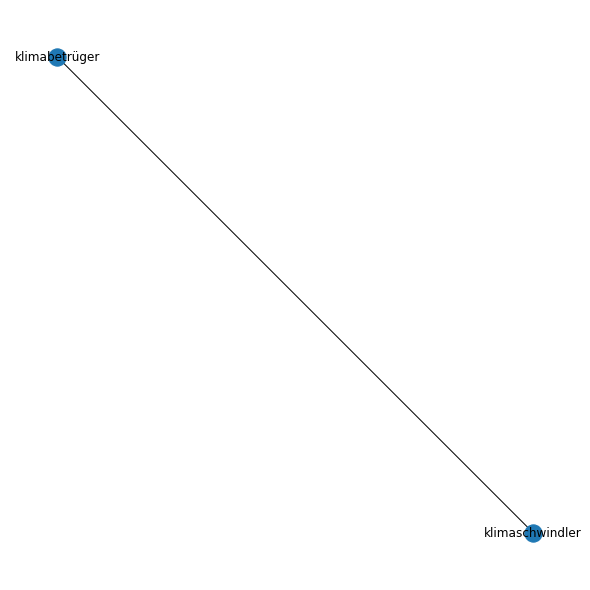

In [86]:
#get_network_graph(test, None)
get_network_graph(test, ["betrüger"])

# 4. Dependency Parsing
- [X] get dependencies of pro_sent_df and con_sent_df
- [X] check which words are dependent on our compounds 


German/English dependency labels
https://github.com/explosion/spaCy/blob/master/spacy/glossary.py  
https://www.ims.uni-stuttgart.de/documents/ressourcen/korpora/tiger-corpus/annotation/tiger_scheme-syntax.pdf

In [611]:
from spacy import displacy

#### 4.1 Retrieve Dependencies

Lets retrieve dependency information with the `spaCy` library for our context data frames. 

The function `get_dependencies_recursive` retrieves all modifiers recursively to also check for cases such as found in: *"Über den weltweit bekanntesten (und wohl aggressivsten) Klimaaktivisten Bill McKibben"*

We want *weltweit*, *bekanntesten*, *wohl* and *aggressivsten* to be found as well. Therefore the following function takes heads which are modifiers of the compound and looks recursively for their dependents too. 

In [816]:
def get_dependencies_recursive(df):
    
    """
    This function recursively retrieves the dependencies of words being dependent of a compound word. 
    Arg: 
        df: a data frame containing the compound words for which we want to count the POS tags of the dependent words.
    Returns: 
        A nested dictionary consisting of the compound words as keys and the dependency information, 
        i.e. the dependent word, the POS tag of the dependent word, the dependency tag, tag explanation, the sentence itself.
    """   
    
    deps = dict.fromkeys(set(df.pattern)) # initiate a dictionary with the compounds as keys
    mods = ["mo", "mnr", "nk"] # the list of dependency tags we are interested in
    pos = ["ADJA", "ADJD", "PAV", "PROAV", "PDAT", "PIAT", "PIDAT",
          "PPOSAT", "PRELAT", "PTKA", "PWAT", "PWAV", "ADJ", "ADP", "ADV"] # the list of POS tags we are interested in
    
    # iterate over rows of data frame 
    for index, row in df.iterrows():
        
        #deps[row["pattern"]] = list() # initiate empty list for each key in dict
        doc = nlp(row["keyword"]) # retrieve sentence with keyword for according row

        # for each token in the sentence 
        for token in doc:
            
            # check for words being dependent on our compound word, i.e. the compound is the head 
            if str(token.head.text).lower().startswith(row["pattern"].lower()):
                
                # if the token is a modifier (i.e. token has one of the modifier tags and one of the POS tags that we defined above)
                if token.dep_ in mods and token.tag_ in pos:
                    
                    # if key has no values so far
                    if deps[row["pattern"]] == None:
                        
                        # initiate empty list for each key in dict
                        deps[row["pattern"]] = list()
                
                    else:
                        pass
                        
                    # append information (lemma, token, pos tag, dependency tag, head word, tag explanation and sentence) to dependency list
                    deps[row["pattern"]].append([token.lemma_, token.text, token.tag_, token.dep_, token.head.text, str(spacy.explain(token.dep_)), doc])
                        
                    # use the new found word as new head 
                    new_head = token.text
                    
                    # check if we have words that are dependent on our new head
                    for token in doc:
                        
                        # if yes
                        if token.head.text == new_head:
                            
                            # and if the token is a modifier (i.e. token has one of the modifier tags and one of the POS tags that we defined above)
                            if token.dep_ in mods and token.tag_ in pos:
                                
                                # append it to our list
                                deps[row["pattern"]].append([token.lemma_, token.text, token.tag_, token.dep_, token.head.text, str(spacy.explain(token.dep_)), doc])

            # if we have a conjunct of one of the modifiers and another modifier
            if token.head.text == "und" and token.tag_ in pos and token.dep_ == "cj":
                
                # if key already has values 
                if deps[row["pattern"]] != None:
                    
                    # append to list
                    deps[row["pattern"]].append([token.lemma_, token.text, token.tag_, token.dep_, token.head.text, str(spacy.explain(token.dep_)), doc])
                
                else:
                    pass
                
                # use token as new head 
                next_head = token.text
                
                # check for dependent words 
                for token in doc:
                    
                    # if yes
                    if token.head.text == next_head: 
                        
                        # and if the token is a modifier (i.e. token has one of the modifier tags and one of the POS tags that we defined above)
                        if token.dep_ in mods and token.tag_ in pos:
                            
                            # if key already has values
                            if deps[row["pattern"]] != None:
                                
                                # append information to list
                                deps[row["pattern"]].append([token.lemma_, token.text, token.tag_, token.dep_, token.head.text, str(spacy.explain(token.dep_)), doc])
                                
                            else:
                                pass

                
    # return final dictionary with dependency information for each compound in the data frame
    return deps 

#### 4.2 Retrieve Modifiers from Dependencies

Next, since the `get_dependencies_recursive` function outputs a dictionary full of dependency information for each compound, we use the function `get_mods` to retrieve the modifiers from the `get_dependencies_recursive` output. 

In [817]:
def get_mods(column):
    
    """
    This function retrieves the modifiers of the column created via the "get_dependencies_recursive" above. 
    Arg: 
        df: a data frame column containing list of dependencies from which we want to retrieve the very first element.
    Returns: 
        A list of modifier words for each compound word if possible, else 0.
    """ 
    
    mods = [] # initiate empty list
    
    # for each list of dependencies
    for deps in column:
        
        # if list ist empty
        if column == "[]":
            return 0 # return 0
           
        else:
            # get first element and save to new list
            mods.append(deps[0])
            
    return mods # return list of modifiers

Let's apply both functions and save the dependency information to a new column `dependencies` and the list of modifiers to a new column `modifiers`. 

In [818]:
# apply function to data frames 
con_deps = get_dependencies_recursive(con_context)
pro_deps = get_dependencies_recursive(pro_context)

# retrieve dependencies and save to new column in our data frame 
pro_context["dependencies"] = pro_context['pattern'].map(pro_deps)
con_context["dependencies"] = con_context['pattern'].map(con_deps)

In [819]:
# turn None into empty list 
pro_context.fillna(value="[]", inplace=True)
con_context.fillna(value="[]", inplace=True)

# apply modifier function to find all modifiers and save to new column "modifiers"
pro_context["modifiers"] = pro_context.dependencies.apply(get_mods)
con_context["modifiers"] = con_context.dependencies.apply(get_mods)

#### 4.3 Visualization of the Process

To visualize what just happened in the functions we applied before, let's have a look at the following code. We will use the previously mentioned example phrase from the C2022 corpus: 
*Über den weltweit bekanntesten und wohl aggressivsten Klimaaktivisten Bill McKibben*

For this phrase, we will retrieve the *tokens*, *dependency labels*, the according *heads* and a brief *explanation* of the dependency tag. The ouput is shown below.

In [639]:
text = "Über den weltweit bekanntesten und wohl aggressivsten Klimaaktivisten Bill McKibben"

print(f"{'Token':{15}} {'Dependence':{15}} {'Head Text':{20}}  {'Dependency Explained'} ")
for token in nlp(text):
     print(f"{token.text:{15}} {token.dep_+' =>':{13}}   {token.head.text:{20}}  {spacy.explain(token.dep_)} ")

Token           dependence      head text             Dependency explained 
Über            ROOT =>         Über                  root 
den             nk =>           Klimaaktivisten       noun kernel element 
weltweit        mo =>           bekanntesten          modifier 
bekanntesten    nk =>           Klimaaktivisten       noun kernel element 
und             cd =>           bekanntesten          coordinating conjunction 
wohl            mo =>           aggressivsten         modifier 
aggressivsten   cj =>           und                   conjunct 
Klimaaktivisten nk =>           Über                  noun kernel element 
Bill            pnc =>          McKibben              proper noun component 
McKibben        nk =>           Klimaaktivisten       noun kernel element 


Heads are tagges as `ROOT`, a full list of the remaining dependency tags can be found here: https://github.com/explosion/spaCy/blob/master/spacy/glossary.py

Our function `get_dependencies_recursive` now seeks to retrieve all words that are being dependent on our compound word (and that are an adjective or adverb).

Accordingly, for this example, our code retrieves the words (in this order):

**bekanntesten** => **weltweit**  
**aggressivsten** => **wohl** 

The syntactic structure of the phrase can also be visualized as a graph of dependencies as given here:

In [645]:
ex1 = "Über den weltweit bekanntesten und wohl aggressivsten Klimaaktivisten Bill McKibben"

doc = nlp(ex1)
displacy.render(doc, style="dep")

# to save the plot please un-comment the following lines

#dep_plot = displacy.render(doc, style='dep', jupyter=False)
#output_path = Path("../../plots/dependency_plot.svg")
#output_path.open("w", encoding="utf-8").write(dep_plot);

### TO DELETE FROM HERE


#### Test here if you want to apply this to a sentence for testing 

In [ ]:
def get_dependencies_recursive(df):
    
    """
    This function recursively retrieves the dependencies of words being dependent of a compound word. 
    Arg: 
        df: a data frame containing the compound words for which we want to count the POS tags of the dependent words.
    Returns: 
        A nested dictionary consisting of the compound words as keys and the dependency information, 
        i.e. the dependent word, the POS tag of the dependent word, the dependency tag, tag explanation, the sentence itself.
    """   
    
    deps = dict.fromkeys(set(df.pattern)) # initiate a dictionary with the compounds as keys
    mods = ["mo", "mnr", "nk"] # the list of dependency tags we are interested in
    pos = ["ADJA", "ADJD", "PAV", "PROAV", "PDAT", "PIAT", "PIDAT",
          "PPOSAT", "PRELAT", "PTKA", "PWAT", "PWAV", "ADJ", "ADP", "ADV"] # the list of POS tags we are interested in
    
    # iterate over rows of data frame 
    for index, row in df.iterrows():
        
        #deps[row["pattern"]] = list() # initiate empty list for each key in dict
        doc = nlp(row["keyword"]) # retrieve sentence with keyword for according row

        # for each token in the sentence 
        for token in doc:
            
            # check for words being dependent on our compound word, i.e. the compound is the head 
            if str(token.head.text).lower().startswith(row["pattern"].lower()):
                
                # if the token is a modifier (i.e. token has one of the modifier tags and one of the POS tags that we defined above)
                if token.dep_ in mods and token.tag_ in pos:
                    
                    # if key has no values so far
                    if deps[row["pattern"]] == None:
                        
                        # initiate empty list for each key in dict
                        deps[row["pattern"]] = list()
                
                    else:
                        pass
                        
                    # append information (token, pos tag, dependency tag, head word, tag explanation and sentence) to dependency list
                    deps[row["pattern"]].append([token.lemma_, token.tag_, token.dep_, token.head.text, str(spacy.explain(token.dep_)), doc])
                        
                    # use the new found word as new head 
                    new_head = token.text
                    
                    # check if we have words that are dependent on our new head
                    for token in doc:
                        
                        # if yes
                        if token.head.text == new_head:
                            
                            # and if the token is a modifier (i.e. token has one of the modifier tags and one of the POS tags that we defined above)
                            if token.dep_ in mods and token.tag_ in pos:
                                
                                # append it to our list
                                deps[row["pattern"]].append([token.lemma_, token.tag_, token.dep_, token.head.text, str(spacy.explain(token.dep_)), doc])

            # if we have a conjunct of one of the modifiers and another modifier
            if token.head.text == "und" and token.tag_ in pos and token.dep_ == "cj":
                
                # if key already has values 
                if deps[row["pattern"]] != None:
                    
                    # append to list
                    deps[row["pattern"]].append([token.lemma_, token.tag_, token.dep_, token.head.text, str(spacy.explain(token.dep_)), doc])
                
                else:
                    pass
                
                # use token as new head 
                next_head = token.text
                
                # check for dependent words 
                for token in doc:
                    
                    # if yes
                    if token.head.text == next_head: 
                        
                        # and if the token is a modifier (i.e. token has one of the modifier tags and one of the POS tags that we defined above)
                        if token.dep_ in mods and token.tag_ in pos:
                            
                            # if key already has values
                            if deps[row["pattern"]] != None:
                                
                                # append information to list
                                deps[row["pattern"]].append([token.lemma_, token.tag_, token.dep_, token.head.text, str(spacy.explain(token.dep_)), doc])
                                
                            else:
                                pass
                            
            # if we have coordinating conjunction, check for its head
            if token.dep_ == "cd": 
                another_head = token.head.text
                
                # check for dependent words 
                for token in doc:
                    
                    # if yes
                    if token.head.text == another_head: 
                        
                        # and if the token is a modifier (i.e. token has one of the modifier tags and one of the POS tags that we defined above)
                        if token.dep_ in mods and token.tag_ in pos:
                            
                            # if key already has values
                            if deps[row["pattern"]] != None:
                                
                                # append information to list
                                deps[row["pattern"]].append([token.lemma_, token.tag_, token.dep_, token.head.text, str(spacy.explain(token.dep_)), doc])
                                
                            else:
                                pass

                
    # return final dictionary with dependency information for each compound in the data frame
    return deps 

In [630]:
con_context[con_context.docname == "eike_13429.txt"][:3].dependencies_rec[68]

[['hundertprozentig',
  'ADJA',
  'nk',
  'Klimaaktivist',
  'noun kernel element',
  Ein hundertprozentiger Klimaaktivist , dieser NobelpreisSchmidt .],
 ['sogenannter',
  'ADJA',
  'nk',
  'Klimaaktivisten',
  'noun kernel element',
  Sorry : von Hirschausen , Dr . von … natürlich ) und nachgehend den absolut gefakten KyotoVertrag gesponsert hat und - wie EIKE kürzlich berichtete - heute noch sogenannte Klimaaktivisten finanziert ( selber haben sie das Vermögen aus Ölproduktion !],
 ['glühender',
  'ADJA',
  'nk',
  'Klimaaktivist',
  'noun kernel element',
  Video der ZDF Propaganda Sendung zur NASA Meldung in : Uhr heute vom Das ZDF , angetrieben von seinem „ Umweltredakteur " Volker Angres , der zwar von der Sache so gut wie nichts versteht , dafür aber ein umso glühenderer Klimaaktivist ist , brachte diese Meldung auch an prominenter Stelle mit passenden Einspielern in der „ heute " Sendung vom .],
 ['umso',
  'ADV',
  'mo',
  'glühenderer',
  'modifier',
  Video der ZDF Propagan

In [598]:
col = con_context[con_context.docname == "eike_13429.txt"][:3]

In [599]:
get_dependencies_recursive(col)

{'klimaaktivist': [['bekannt',
   'ADJA',
   'nk',
   'Klimaaktivisten',
   'noun kernel element',
   Mit schlecht angewandter Statistik lässt sich aber das Gegenteil „ zeigen " ( Teil ) [ ] EIKE : Munich Re Presseinfo : Natur fordert mehr Opfer - Naturkatastrophen wie Erdbeben , Überschwemmungen und Hitzewellen haben deutlich mehr Menschenleben gekostet als im Vorjahr [ ] EIKE : Der Krieg des Klimas gegen die Menschheit Über den weltweit bekanntesten Klimaaktivisten Bill McKibben [ ] Zeit Online .],
  ['weltweit',
   'ADJD',
   'mo',
   'bekanntesten',
   'modifier',
   Mit schlecht angewandter Statistik lässt sich aber das Gegenteil „ zeigen " ( Teil ) [ ] EIKE : Munich Re Presseinfo : Natur fordert mehr Opfer - Naturkatastrophen wie Erdbeben , Überschwemmungen und Hitzewellen haben deutlich mehr Menschenleben gekostet als im Vorjahr [ ] EIKE : Der Krieg des Klimas gegen die Menschheit Über den weltweit bekanntesten Klimaaktivisten Bill McKibben [ ] Zeit Online .]]}

In [607]:
#text2 = "Ich rede hier über einen richtig schlimmen und blöden Klimaaktivisten"
text2 = "Über den weltweit bekanntesten (und wohl aggressivsten) Klimaaktivisten Bill McKibben"

text3 = "Über den weltweit bekanntesten und wohl aggressivsten Klimaaktivisten Bill McKibben"



doc = nlp(text3)

mods = ["mo", "mnr", "nk"] # the list of dependency tags we are interested in
pos = ["ADJA", "ADJD", "PAV", "PROAV", "PDAT", "PIAT", "PIDAT",
          "PPOSAT", "PRELAT", "PTKA", "PWAT", "PWAV", "ADJ", "ADP", "ADV"]

deps = []
# for each token in the sentence 
for token in doc:
            
    # check for words being dependent on our compound word, i.e. the compound is the head 
    if token.head.text == "Klimaaktivisten": 
                
        # if the token is a modifier (i.e. token has one of the modifier tags and one of the POS tags that we defined above)
        if token.dep_ in mods and token.tag_ in pos:
                    
            # append to list
            deps.append([token.text, token.tag_, token.dep_])
            
            # use this token as new head and check for dependent words
            new_head = token.text
            
            # for all tokens in text
            for token in doc:
                # if the new head is head of a token
                if token.head.text == new_head: 
    
                    # if the token is a modifier (i.e. token has one of the modifier tags and one of the POS tags that we defined above)
                    if token.dep_ in mods and token.tag_ in pos:
                        deps.append([token.text, token.tag_, token.dep_])  
    
    # if we have a conjunct of one of the 
    if token.head.text == "und" and token.tag_ in pos and token.dep_ == "cj":
        deps.append([token.text, token.tag_, token.dep_])

                # use token as new head 
        next_head = token.text
                
                # check for dependent words 
        for token in doc:
                    
                # if yes
            if token.head.text == next_head: 
                        
                        # and if the token is a modifier (i.e. token has one of the modifier tags and one of the POS tags that we defined above)
                if token.dep_ in mods and token.tag_ in pos:
                    deps.append([token.text, token.tag_, token.dep_])
                            # if key already has values
                    
                    
    else:
        pass

In [608]:
deps

[['bekanntesten', 'ADJD', 'nk'],
 ['weltweit', 'ADJD', 'mo'],
 ['aggressivsten', 'ADJA', 'cj'],
 ['wohl', 'ADV', 'mo']]

In [519]:
con_ner_df

,pattern,full,entities,persons,organisations,locations,compound_dep,pos_deps,bert_prep,bert,blob,blob_bin,blob_prep,blob_prep_bin,dependencies,modifiers
0,Klimaaktivismus,Viele der Neubekehrten wechselten von extremer...,"[['evangelischen', 'MISC'], ['Miami', 'LOC'], ...","{'Richard Cizik', 'Sohn Jose', 'Klimaaktivismu...","{'NY Times', 'New Evangelical Partnership for ...","{'Stadt', 'Miami', 'Erde?', 'Pazifik', 'Verein...","{'nk': 1, 'sb': 1, 'ag': 1}",{'ART': 2},negative,neutral,0.168750,neutral,0.0,neutral,[],NaN
1,Klimaaktivist,Ein guter Punkt. Die Erwärmungsprognosen schie...,"[['Pegelmessungen', 'PER'], ['PunktoOzeanversa...",{'https://funpot.net/daten/key_xyz/6e/funpot00...,"{'Taifunaktivität"".', 'IPCC', 'DDR', 'falsch!'...","{'New Yorker', 'Klimauntergang prophezeit.', '...","{'ROOT': 1, 'pd': 1, 'nk': 3, 'pnc': 1, 'sb': ...","{'ART': 6, 'ADJA': 5, 'NN': 1, '$': 2, '': 2, ...",positive,neutral,0.058530,neutral,0.0,neutral,"[[hundertprozentiger, ADJA, nk, noun kernel el...","[hundertprozentiger, sogenannte, glühenderer, ..."
2,Klimaaktivistin,"Detlev Ganten, Founding President, World Healt...","[['Detlev Ganten', 'PER'], ['Founding Presiden...","{'Max Mutzke, Sänger, Songwriter, Musiker', 'M...","{'UK Bastian Pastewka', 'University of Oxford'...",set(),"{'cj': 1, 'ag': 1, 'pd': 1}","{'ART': 2, 'ADJA': 1, '$': 1, '': 1, 'VVFIN': 1}",negative,neutral,-0.010256,neutral,0.0,neutral,"[[jungen, ADJA, nk, noun kernel element, (Dok,...",[jungen]
3,Klimaalarm,"„Und das reicht, damit es Pflanzen gibt?"" „Sch...","[['Fenster!', 'ORG'], ['antworten?„So', 'MISC'...","{'Hendricks', 'Freud', 'Heiligenroth', 'Uli We...","{'weh', 'IRMA', 'deutschen Medienlandschaft.',...","{'Stefan-Boltzmann', 'Magreb', 'Tokio', 'Novo-...","{'pd': 2, 'oa': 8, 'nk': 11, 'sb': 6, 'ROOT': ...","{'NE': 2, 'ART': 9, 'ADJA': 3, 'NN': 3, '$.': ...",negative,neutral,0.063872,neutral,0.0,neutral,"[[weiteren, ADJA, nk, noun kernel element, (Au...","[weiteren, einigen, Linke, globalen, politisch..."
4,Klimaalarmist,"„Und das reicht, damit es Pflanzen gibt?"" „Sch...","[['Fenster!', 'ORG'], ['antworten?„So', 'MISC'...","{'Heiligenroth', 'Klimagipfel', 'Nicholas Ster...","{'IRMA', 'REBELLION', 'deutschen Medienlandsch...","{'Magreb', 'Bayern', 'Rhein', 'Konsens', 'Euro...",{'app': 1},"{'ART': 1, 'NE': 1, 'NN': 1}",negative,neutral,0.057889,neutral,0.0,neutral,"[[Linke, ADJA, nk, noun kernel element, (Linke...","[Linke, nur, seine, lokalen, alle, Diffamieren..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,Klimaweltuntergang,Bleiben Sie Buchbinder… so ist es! Eine dünne ...,"[['Wärmezufuhr', 'LOC'], ['Treibhausvoodoo', '...",set(),set(),"{'Wärmezufuhr', 'Treibhausvoodoo'}",{},{},negative,neutral,0.065185,neutral,0.0,neutral,[],NaN
134,Klimazar,"Buttigiegs Hauptargument im Wahlkampf war, er ...","[['Buttigiegs Hauptargument', 'LOC'], ['Michig...","{'Joe Bidens', 'Michigan', 'McCarthy', 'Jennif...","{'Emission', 'EPA'}","{'Buttigiegs Hauptargument', 'Weißen Haus'}",{},{},negative,neutral,0.111111,neutral,0.0,neutral,[],NaN
135,Klimazerstörer,Hier die Tondatei (mit Dank an R. Hoffmann) de...,"[['Tondatei', 'ORG'], ['R. Hoffmann', 'PER'], ...",{'R. Hoffmann'},"{'EU/', 'CO2-Klimaerwärmung!', 'darob', 'Tonda...","{'Schweiz', 'Frankreich', 'Deutschland', 'D', ...",{'nk': 1},{'ART': 1},negative,negative,-0.225000,negative,0.0,neutral,[],NaN
136,Klimazirkus,Jugendliche in die Länderdelegation Deutschlan...,"[['Länderdelegation Deutschlands', 'ORG'], ['J...","{'Kempfert', 'Welcher Darstellung', 'Propagand...","{'DMI', 'VDI, Institutionen', 'KT-Diagramm', '...","{'Nordwestdeutschland', 'Berlin', 'Idioten', '...","{'nk': 3, 'sb': 3, 'oa': 1, 'cj': 1, 'da': 1}","{'ART': 4, 'PIAT': 1, 'APPR': 2, '$(': 2, 'PRO...",negative,neutral,-0.049479,neutral,0.0,neutral,"[[irgendeinen, PIAT, nk, noun kernel element, ...","[irgendeinen, damit, auch, dieser, ganze, abla..."


In [448]:
#pro_ner_df # save to pro_full????

#### 4.2 Save Information

Save the information to the data frame `pro_sent_df` and `con_sent_df` (these data frames already contain the information from the Named-Entity Recognition part).

- the new column `dependencies` contains the dependencies of words being dependent on the compound word in a list format.
- the new column `modifiers` contains the modifiers retrieved from the `dependencies` columns.

In [703]:
# save new information to csv files
pro_ner_df.to_csv("textmining/pro_full.csv", index = False)
con_ner_df.to_csv("textmining/con_full.csv", index = False)

#### 4.3 Visualization of Dependencies (Example)

In [613]:
ex1 = "Über den weltweit bekanntesten und wohl aggressivsten Klimaaktivisten Bill McKibben"

doc = nlp(ex1)
dep_plot = displacy.render(doc, style='dep', jupyter=False)

output_path = Path("../../plots/dependency_plot.svg")
output_path.open("w", encoding="utf-8").write(dep_plot);

#### Comparison of our two functions

In [652]:
# check if we have differences
np.where(con_ner_df.modifiers == con_ner_df.modifiers_rec)

(array([ 45,  80,  82, 106, 123]),)

In [ ]:
test = con_context.dependencies[68]

for element in test:
    print(element)
    print("_"*10)
    np = element[1] + " " + element[4]
    
    print(np)
    print("_"*10)

# 5. Sentiment Analysis
- [X] get tokens
- [X] apply stop lists (optional)
- [X] get sentiment of pre and post sentences
- [X] save sentiment to dataframe 

Further Ideas:
- [ ] thesis: compare nltk vs. spacy for sentiment (or also textblob)
- [ ] manually evaluate accuracy for a subset of 100-200 words



In [425]:
# load files 
# load data frames with NER / Sentiment / DEP information
con_sentiment = pd.read_csv("textmining/con_sentiment.csv")
pro_sentiment = pd.read_csv("textmining/pro_sentiment.csv")

In [9]:
#kwic_pro_sent;

In [234]:
#from spacytextblob.spacytextblob import SpacyTextBlob
#nlp.add_pipe('spacytextblob')

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

# load stop words from nltk
stop_words = stopwords.words('german')

[nltk_data] Downloading package stopwords to /Users/anna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/anna/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [111]:
#!pip3 install germansentiment

## 5.1 Preprocessing ???


## 5.2 Apply Sentiment Tools

### 5.2.1 German BERT 

In [820]:
from germansentiment import SentimentModel
model = SentimentModel()

In [821]:
def get_bert(text):
        
    #t = preprocessing(str(text))[0]
    #t = [' '.join(t)]
    pol = model.predict_sentiment([str(text)])
        
    return pol[0]

In [822]:
#get_bert("ich habe einen guten tag")

In [901]:
pro_context["bert"] = pro_context.full.apply(get_bert)

In [902]:
con_context["bert"] = con_context.full.apply(get_bert)

In [904]:
con_context

,docname,from,to,pre,keyword,post,pattern,full,entities,persons,organisations,PERS,dependencies,modifiers,bert
0,eike_00764.txt,8,8,Werner Kirstein Universität Leipzig Kirstein s...,"Ganz klar , dass einige Wirtschaftszweige und ...","Volkswirtschaftlich wird , bis hin zum Verbrau...",klimaabzockerei,Werner Kirstein Universität Leipzig Kirstein s...,"[[Werner Kirstein, PER], [Kirstein, PER], [Kir...","{Werner Kirstein, Kirstein, Wirtschaftsexperte}",{KlimaAbzockerei},{Werner Kirstein},[],0,neutral
1,eike_08491.txt,4,4,Viele der Neubekehrten wechselten von extremer...,Er war Mitglied in der Kirche der „ religiösen...,[ Richard Cizik ist Präsident der New Evangeli...,klimaaktivismus,Viele der Neubekehrten wechselten von extremer...,"[[evangelischen, MISC], [Miami, LOC], [Richard...","{Link, Ciziks, Zögernd, Jesus, Jim Ball, Richa...","{National Association of Evangelicals, Neuen E...","{Jim Ball, Richard Cizik}",[],0,neutral
2,eike_08491.txt,9,9,Er war Mitglied in der Kirche der „ religiösen...,Copyright nicht kopiert ] „ Wir hörten vier Ta...,"Der Bürgermeister von Miami , Tomás Regalado ,...",klimaaktivismus,Er war Mitglied in der Kirche der „ religiösen...,"[[Kirche, ORG], [Jim Ball, PER], [Evangelical ...","{Sohn, Tomás Regalado, Jim Ball, .Copyright, L...","{niederländischen Deltares Research Institute,...","{Richard Cizik, Jim Ball}",[],0,neutral
3,eike_11249.txt,113,113,Was bedeutet das für das Klima auf der Erde ? ...,Unvorstellbar für hohe Priester des Klimaaktiv...,"Die Sonne zum Beispiel ? Nein , kann nicht sei...",klimaaktivismus,Was bedeutet das für das Klima auf der Erde ? ...,"[[Erde, LOC], [Mär, PER], [.Unvorstellbar, MISC]]",{Mär},{},{},[],0,neutral
4,eike_00911.txt,23,23,Ein guter Punkt . Die Erwärmungsprognosen schi...,"Ein hundertprozentiger Klimaaktivist , dieser ...",Von der Sache selber scheint der hauptberuflic...,klimaaktivist,Ein guter Punkt . Die Erwärmungsprognosen schi...,"[[Erwärmungsprognosen, LOC], [Erwärmungspause,...","{Brian Schmidt, Schmidt, Schellnhuber}","{Umweltenzyklika, NobelpreisSchmidt, IPCC}",{Hans Joachim Schellnhuber},"[[hundertprozentig, hundertprozentiger, ADJA, ...","[hundertprozentig, sogenannter, glühender, ums...",neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1905,eike_04459.txt,462,462,Insgesamt ist seine Schlussfolgerung von der U...,Der Klimazirkus und EESch … ist offizielle Pol...,"Die . Macht auf Staatsseite , die dem Staat üb...",klimazirkus,Insgesamt ist seine Schlussfolgerung von der U...,"[[EEG, MISC], [die Grünen rot !, ORG], [PC, MI...",{},"{die Grünen rot !, VDI}",{},"[[irgendein, irgendeinen, PDAT, nk, Klimazirku...","[irgendein, damit, auch, dieser, ganz, ablaufe...",neutral
1906,c19.txt,85,85,Um unseren Planeten geht es darin . Und um den...,Und seither gilt dieses Gebot als Grundlage im...,"Von Schellnhuber entdeckt . » Ulli Kulke , Wet...",klimazirkus,Um unseren Planeten geht es darin . Und um den...,"[[Hans Joachim Schellnhuber, PER], [Schellnhub...","{Ulli Kulke, Hans Joachim Schellnhuber, Schell...",{Wett Online},"{Ulli Kulke, Hans Joachim Schellnhuber}","[[irgendein, irgendeinen, PDAT, nk, Klimazirku...","[irgendein, damit, auch, dieser, ganz, ablaufe...",neutral
1907,eike_00149.txt,180,180,Dass Herr Prof . Schellnhuber eher zu den stri...,Leider ist es damit inzwischen so weit gekomme...,Die Kirche kann aufgrund des von ihr ausgespro...,klimazunft,Dass Herr Prof . Schellnhuber eher zu den stri...,"[[Schellnhuber, PER], [TRAILER, MISC], [H J Sc...","{H J Schellnhuber, Schellnhuber}","{AfD, KlimawandelDogmas, EIKE, Kirche}",{Hans Joachim Schellnhuber},"[[führend, führenden, ADJA, nk, Klimazunft, no...",[führend],neutral
1908,eike_01745.txt,707,707,"Kann man machen , man kann sich aber auch einf...",Doch zum Glück für die Klimazunft gibt es imme...,Das mit den „ Temperaturermittlungen in den We...,klimazunft,"Kann man machen , man kann sich aber auch einf...","[[Etc, MISC], [Etc, MISC], [.Doch, LOC], [Pete...",{Petersen},{},{Sverre P

`bert_prep` = sentiment analysis using german bert model and preprocessing
`bert` = sentiment analysis using german bert model and no preprocessing 

In [930]:
# save new information to csv files
pro_context.to_csv("../output/pro_ner.csv", index = False)
con_context.to_csv("../output/con_ner.csv", index = False)

### 5.2.2 TextBlob

In [6]:
#!pip3 install -U textblob-de

In [907]:
from textblob_de import TextBlobDE as TextBlob;

In [908]:
def get_blob(text):
        
    #t = preprocessing(str(text))[0]
    #t = [' '.join(t)]
    blob = TextBlob(str(text))
    
    return blob.sentiment[0]
        
    #return model.predict_sentiment([str(text)])
    
def convert_sentiment(value, threshold):
    if value >= threshold:
        new_value = "positive"
        
    if value <= -(threshold):
        new_value = "negative"
        
    else:
        new_value = "neutral"
        
    return new_value

In [929]:
# apply to data frame 
pro_context["blob"] = pro_context.full.apply(get_blob)
con_context["blob"] = con_context.full.apply(get_blob)

## 5.3 Evaluate Sentiment Tools

### 5.3.1 Check Sentiment
In the following we will retrieve the texts where our sentiment tools return different polarities. These entries will be checked manually for its sentiment. Afterwards we can potentially decide which sentiment tool is better for our text type. 

Firstly, we will convert the polarity scores we retrieved via the TextBlob tool into discrete labels: `negative`, `neutral`, `positive` to be able to compare them to the polarity labels we got via GermanBert. 

To see which threshold for TextBlob gives us the most similar polarity labels (compared to the GermanBert output), different threshold values (0.0, 0.1, 0.2, 0.3, 0.4) were tested for the conversion into the discrete label format. This is done in the `test_parameters` function below. 

In [931]:
def test_parameters(df):
    diff_scores = []
    
    # for different threshold values
    for x in np.arange(0.0, 0.50, 0.10):
        
        # get discrete labels
        df["blob_bin"] = df.blob.apply(convert_sentiment, threshold = round(x,2))
        
        # compute difference of columns
        diff = len(df[(df['bert'] == df['blob_bin']) == False])
        
        # save scores to list in format: threshold, difference count
        diff_scores.append([round(x,2), diff])
        
    # return minimum of difference count and list of difference counts
    return min(diff_scores, key=lambda x: x[1]), diff_scores

In [932]:
# apply function to data frames 
pro_diff = test_parameters(pro_context)
con_diff = test_parameters(con_context)

In [933]:
con_diff

([0.4, 472], [[0.0, 704], [0.1, 550], [0.2, 510], [0.3, 477], [0.4, 472]])

Now, we can have a look at the difference scores that the range of parameters gives us (the first value is the threshold parameter, the second value is the difference count):

In [934]:
print("Contra dataframe differences:\n\n", tabulate(con_diff[1], headers=["threshold", "difference score"]))
print("\nPro dataframe differences:\n\n", tabulate(pro_diff[1], headers=["threshold", "difference score"]))

Contra dataframe differences:

   threshold    difference score
-----------  ------------------
        0                   704
        0.1                 550
        0.2                 510
        0.3                 477
        0.4                 472

Pro dataframe differences:

   threshold    difference score
-----------  ------------------
        0                   279
        0.1                 212
        0.2                 188
        0.3                 176
        0.4                 173


In [935]:
# convert continuous sentiment score to discrete score 
con_context["blob_labels"] = con_context.blob.apply(convert_sentiment, threshold = 0.4)
pro_context["blob_labels"] = pro_context.blob.apply(convert_sentiment, threshold = 0.4)


In [936]:
# retrieve columns where we have different sentiment scores 
con_sentiment_diff = con_context[(con_context['bert'] == con_context['blob_bin']) == False]
pro_sentiment_diff = pro_context[(pro_context['bert'] == pro_context['blob_bin']) == False]


Let's save it to csv files to be able to explore them outside of Python and evaluate the sentiment tools manually. 

In [937]:
# save new information to csv files
con_sentiment_diff.to_csv("../evaluation/con_sentiment_diff.csv", index = False)
pro_sentiment_diff.to_csv("../evaluation/pro_sentiment_diff.csv", index = False)

### 5.3.2 Retrieve main Polarity for each Klima Compound
To get the prevailing polarity for each compound, we run the following code:

In [921]:
pro_context.head()

,docname,from,to,pre,keyword,post,pattern,full,entities,persons,organisations,PERS,dependencies,modifiers,bert,blob,blob_bin,blob_labels
0,fff_de_00488.txt,5,5,Aber das macht nichts . Denn Du kannst trotzde...,Mit Deiner Spende unterstützt Du unseren Klima...,Jetzt spenden : Alle Zahlungen gehen ohne Abzu...,klimaaktivismus,Aber das macht nichts . Denn Du kannst trotzde...,"[[MobiPaket, ORG], [hilftst, PER], [Du, PER], ...","{hilftst, Du}","{MobiPaket, Vereins fairsichern community e.V,...",{},"[[unser, unseren, PPOSAT, nk, Klimaaktivismus,...","[unser, weiß]",neutral,0.200000,neutral,neutral
1,farn236.txt,2,2,""" Auf Seiten beschreibt die Broschüre zunächst...","In einem weiteren Kapitel geht es darum , wie ...",Ein zentraler Teil der Broschüre ist ebenso di...,klimaaktivismus,""" Auf Seiten beschreibt die Broschüre zunächst...","[[co2Emissionen, LOC], [BUNDjugend, ORG]]",{},{BUNDjugend},{},"[[unser, unseren, PPOSAT, nk, Klimaaktivismus,...","[unser, weiß]",neutral,-0.250000,neutral,neutral
2,farn260.txt,288,288,"„ Wenn es nach mir ginge , könnte die Klimaerw...",Auch seine Esoterik macht Storl anschlussfähig...,Die Simplizität der angebotenen Maßnahmen biet...,klimaaktivismus,"„ Wenn es nach mir ginge , könnte die Klimaerw...","[[Inseln, LOC], [Pina Colada, PER], [EW, MISC]...","{Ken Jebsen, Storl, Ken Jebsens, Pina Colada}",{KlimaAktivismus},"{Ken Jebsen, Wolf Dieter Storl}","[[unser, unseren, PPOSAT, nk, Klimaaktivismus,...","[unser, weiß]",neutral,0.270370,neutral,neutral
3,gerzero_00022.txt,29,29,Alle eint dasselbe Ziel : Sie wollen ihre Heim...,""" Dabei schlägt den Klimaaktivistinnen am Anfa...","Oberbürgermeister Matthias Klopfer , SPD , bez...",klimaaktivist,Alle eint dasselbe Ziel : Sie wollen ihre Heim...,"[[Schorndorf, LOC], [Team Klimaentscheide, ORG...","{GermanZero Dörte Schnitzer, Matthias Klopfer,...","{SPD, GermanZero, Team Klimaentscheide, Klimas...","{Ines Gütt, Dörte Schnitzer, Matthias Klopfer}","[[auch, auch, ADV, mo, Klimaaktivistin, modifi...","[auch, 24jährig, bös, vieler, anderer, anderer...",neutral,-0.030000,neutral,neutral
4,fff_de_00330.txt,14,14,Kurz zuvor war das bei weitem nicht ausreichen...,Unter ihnen auch die 24jährige Klimaaktivistin...,In der Berichterstattung über eine Pressekonfe...,klimaaktivist,Kurz zuvor war das bei weitem nicht ausreichen...,"[[Mainz, LOC], [Davos, LOC], [Klimaaktivistin ...","{Vanessa, Klimaaktivistin Vanessa Nakate}","{Fridays for FutureBewegung, Fridays for Futur...",{Vanessa Nakate},"[[auch, auch, ADV, mo, Klimaaktivistin, modifi...","[auch, 24jährig, bös, vieler, anderer, anderer...",neutral,-0.057407,neutral,neutral


In [938]:
def convert_dataframe(df):
    df["text_by_compound"] =  df[["pattern", "full"]].groupby(['pattern'])['full'].transform(lambda x: '//'.join(x))
    df = df[['pattern','text_by_compound']].drop_duplicates()
    df = df.reset_index()
    df = df.drop("index", axis = 1)
    df["text_by_compound"] = df["text_by_compound"].apply(lambda x: x.split("//"))

    return df

In [939]:
# apply function to data frame
pro_info = convert_dataframe(pro_context)
con_info = convert_dataframe(con_context)

In [942]:
con_info

,pattern,text_by_compound
0,klimaabzockerei,[Werner Kirstein Universität Leipzig Kirstein ...
1,klimaaktivismus,[Viele der Neubekehrten wechselten von extreme...
2,klimaaktivist,[Ein guter Punkt . Die Erwärmungsprognosen sch...
3,klimaaktivistin,[Dr . Dirk Beckerhoff ( ) Herrn Frank Plasberg...
4,klimaalarm,"[„ Und das reicht , damit es Pflanzen gibt ? ""..."
...,...,...
148,klimaweltuntergang,[Nach einer erstaunlich schnellen Klage von Lu...
149,klimawirklichkeit,"[Das ist pure Dialektik ! Doch wer behauptet ,..."
150,klimazerstörer,[Hier die Tondatei ( mit Dank an R . Hoffmann ...
151,klimazirkus,[Jugendliche in die Länderdelegation Deutschla...


In [943]:
# get most common polarity label for each compound
pro_sentiment_bert = pro_context.groupby(['pattern'])['bert'].max().tolist()
con_sentiment_bert = con_context.groupby(['pattern'])['bert'].max().tolist()
pro_sentiment_blob = pro_context.groupby(['pattern'])['blob_bin'].max().tolist()
con_sentiment_blob = con_context.groupby(['pattern'])['blob_bin'].max().tolist()

# and save to new column in info data frame 
pro_info["bert"] = pro_sentiment_bert
con_info["bert"] = con_sentiment_bert

pro_info["blob"] = pro_sentiment_blob
con_info["blob"] = con_sentiment_blob

In [949]:
# retrieve columns where we have different sentiment scores 
con_sentiment_diff = con_info[(con_info['bert'] == con_info['blob']) == False]
pro_sentiment_diff = pro_info[(pro_info['bert'] == pro_info['blob']) == False]

In [952]:
# save new information to csv files
con_info.to_csv("../output/con_info.csv", index = False)
pro_info.to_csv("../output/pro_info.csv", index = False)

In [953]:
# save new information to csv files
con_sentiment_diff.to_csv("../evaluation/con_sentiment_diff_by_compound.csv", index = False)
pro_sentiment_diff.to_csv("../evaluation/pro_sentiment_diff_by_compound.csv", index = False)

# 6. Pattern Extraction
- spacy rule-based matching

https://predictivehacks.com/rule-based-matching-for-nlp-using-spacy/

https://spacy.io/api/matcher

In [715]:
import spacy
from spacy.matcher import Matcher
from spacy.tokens import Span

In [760]:
doc = nlp("""Sie liegt mit etwa 0,6 bar aber gar nicht soweit weg von unserem Planeten mit 1 bar aber nur 0,04 % CO2. Schon daraus erkennt man Ungereimtheiten. 
          Wenn man den Mond mit einbezieht, der praktisch keine Atmosphäre hat, ergibt sich: CO2 Druck MAX MIN Differenz Venus >90% >90 bar 770 710 60 K Erde <1% 1 
          bar 331 184 147 K Mars >90% 0,6 bar 300 140 160 K Mond 0 0 403 113 290 K also eine Bestätigung der Gasgesetze. In der Atmosphäre gelten auch die Höhenformeln
          für die Abnahme von Druck und Temperatur mit der Höhe. Gleichfalls die Hauptsätze der Thermodynamik.Die Klimaaktivisten behaupten, das CO2 der Atmosphäre 
          würde Wärme zurückstrahlen.Jeglicher Beweis dafür fehlt. Der Versuch, mittels der Strahlungsgesetze dies zu erklären, scheitert am 2. Hauptsatz. 
          Es kann kälteres CO2 der Atmosphäre nicht auf die wärmere Erdoberfläche zurückstrahlen. Wenn CO2 so wirksam wäre, wie behauptet, müsste auch der Luftdruck gestiegen sein. 
          Aber Klimaaktivisten sind nette Menschen""")

In [847]:
doc = nlp("""Klimaaktivisten sind nette Menschen und lachen viel. 
          Ich glaube aber auch, Klimaaktivisten wissen, dass Co2 ein Faktor ist.
          Der bekennende Klimaaktivisten Gisbert Fanselow weiß besonders viel darüber.
          U. a. waren gestern Abend die „Fridays for Future" Klimaaktivisten Franziska Wessel und Jakob Blasel in der Sendung zu Gast.
          Radikale Klimaaktivisten wollen nun einen sofortigen Ausstieg durchsetzen. von Heinz Horeis Peking und Smog
          -  das gehörte in den vergangenen Jahren untrennbar zusammen.""")

## 6.1 Initiate Patterns
- [ ] Keyword + sein + Substantiv
- [ ] Keyword + sein + Adjektiv + Substantiv
- [ ] Substantiv + ist + Keyword
- [ ] Keyword + Verb + ,dass (Version mit und ohne Komma)

In [848]:
opinion_verbs = ["behaupten", "sagen", "meinen", "glauben", "wollen", "denken", "befürchten", "wissen"]

In [854]:
from spacy.matcher import Matcher

matcher = Matcher(nlp.vocab)

# Keyword + sein + ADJ + NOUN
pattern1 = [{"LOWER": {"REGEX": "klimaaktivist*"}}, {"LEMMA": "sein"}, {"POS": "ADJ"},
          {"POS": "NOUN"}]
matcher.add("p1", [pattern1])

# Keyword + sein + NOUN
pattern2 = [{"LOWER": {"REGEX": "klimaaktivist*"}}, {"LEMMA": "sein"},{"POS": "NOUN"}]
matcher.add("p2", [pattern2])

# NOUN + sein + Keyword 
pattern3 = [{"POS": "NOUN"},{"LEMMA": "sein"},{"LOWER": {"REGEX": "klimaaktivist*"}}]
matcher.add("p3", [pattern3])

# Keyword + verb + , + dass ? oder nur Komma????
pattern4 = [{"LOWER": {"REGEX": "klimaaktivist*"}},{"LEMMA": {"IN": opinion_verbs}} ,{"IS_PUNCT": True}]
matcher.add("p4", [pattern4])

# Keyword + Eigenname 
pattern5 = [{"LOWER": {"REGEX": "klimaaktivist*"}},{"POS": "PROPN"}]
matcher.add("p5", [pattern5])

# Keyword + Eigenname mit Nachnamen
pattern6 = [{"LOWER": {"REGEX": "klimaaktivist*"}},{"POS": "PROPN"}, {"POS": "PROPN"}]
matcher.add("p6", [pattern6])

# Keyword + opinion verb 
pattern7 = [{"LOWER": {"REGEX": "klimaaktivist*"}},{"LEMMA": {"IN": opinion_verbs}}]
matcher.add("p7", [pattern7])



#doc = nlp("hello world!")
matches = matcher(doc)
matches

[(294216856376502964, 0, 4),
 (14694915939493522981, 14, 16),
 (12927341502877082044, 14, 17),
 (2932447317883468553, 26, 28),
 (9538583902685184471, 26, 29),
 (2932447317883468553, 46, 48),
 (9538583902685184471, 46, 49),
 (14694915939493522981, 60, 62)]

In [855]:
# TO PRINT FULL SENTENCE AFTER PATTERN MATCH!

matches = matcher(doc)
for match_id, start, end in matches:
    string_id = nlp.vocab.strings[match_id]  
    span = doc[start:end]  
    sents = span.sent  #ADDED THIS LINE
    print(sents)

Klimaaktivisten sind nette Menschen und lachen viel.
Ich glaube aber auch, Klimaaktivisten wissen, dass Co2 ein Faktor ist.
Ich glaube aber auch, Klimaaktivisten wissen, dass Co2 ein Faktor ist.
Der bekennende Klimaaktivisten Gisbert Fanselow weiß besonders viel darüber.
Der bekennende Klimaaktivisten Gisbert Fanselow weiß besonders viel darüber.
Klimaaktivisten Franziska Wessel und Jakob Blasel in der Sendung zu Gast.
Klimaaktivisten Franziska Wessel und Jakob Blasel in der Sendung zu Gast.

          Radikale Klimaaktivisten wollen nun einen sofortigen Ausstieg durchsetzen.


In [856]:
# TO PRINT EXACT MATCH!

for match_id, start, end in matches:
    # Get the string representation 
    string_id = nlp.vocab.strings[match_id]  
    span = doc[start:end]  # The matched span
    print(match_id, string_id, start, end, span.text)

294216856376502964 p1 0 4 Klimaaktivisten sind nette Menschen
14694915939493522981 p7 14 16 Klimaaktivisten wissen
12927341502877082044 p4 14 17 Klimaaktivisten wissen,
2932447317883468553 p5 26 28 Klimaaktivisten Gisbert
9538583902685184471 p6 26 29 Klimaaktivisten Gisbert Fanselow
2932447317883468553 p5 46 48 Klimaaktivisten Franziska
9538583902685184471 p6 46 49 Klimaaktivisten Franziska Wessel
14694915939493522981 p7 60 62 Klimaaktivisten wollen


In [858]:
print("Matches:", set([doc[start:end].text for match_id, start, end in matches][:20]))

Matches: {'Klimaaktivisten Franziska', 'Klimaaktivisten wissen', 'Klimaaktivisten wissen,', 'Klimaaktivisten wollen', 'Klimaaktivisten Gisbert', 'Klimaaktivisten sind nette Menschen', 'Klimaaktivisten Gisbert Fanselow', 'Klimaaktivisten Franziska Wessel'}


### FURTHER READING


http://markneumann.xyz/blog/dependency_matcher/

https://www.kaggle.com/code/randikaweerasinghe/harrypotter-data-extract-with-spacy-pattern-match

In [853]:
# to check rule of a matcher 
#matcher.get("p1")

In [859]:
string1 = "Wie kann man denn auf die Idee kommen, Klimaalarmisten könnten mit solchen statistischen Graphiken etwas anfangen?"

In [861]:
doc = nlp(string1)
#print(doc.text)
for token in doc:
    print(token.text, token.pos_, token.dep_)

Wie ADV mo
kann AUX ROOT
man PRON sb
denn ADV mo
auf ADP mo
die DET nk
Idee NOUN nk
kommen VERB oc
, PUNCT punct
Klimaalarmisten NOUN sb
könnten AUX cj
mit ADP mo
solchen DET nk
statistischen ADJ nk
Graphiken NOUN nk
etwas PRON oa
anfangen VERB oc
? PUNCT punct


# TEST FROM HERE

#### CAN BE DELETED PROBABLY
#### Convert Cell Format
Some of the cell values are saved as a list of one string when loading the csv file. Since we want these values to appear as "bare" strings, we use the following code to convert the cells into the correct format.

In [48]:
# load data frames with NER information
con_sent_df = pd.read_csv("textmining/con_sent_ner.csv")
pro_sent_df = pd.read_csv("textmining/pro_sent_ner.csv")

# use function from beginning of notebook to convert the literal into proper format
con_sent_df["bert_prep"] = con_sent_df.bert_prep.apply(convert_literal)
con_sent_df["bert"] = con_sent_df.bert.apply(convert_literal)


# then turn list into string 
con_sent_df['bert_prep'] = [''.join(map(str, l)) for l in con_sent_df['bert_prep']]
con_sent_df['bert'] = [''.join(map(str, l)) for l in con_sent_df['bert']]

In [49]:
con_sent_df.head()

,pattern,full,entities,persons,organisations,locations,compound_dep,pos_deps,bert_prep,bert
0,Klimaaktivismus,Viele der Neubekehrten wechselten von extremer...,"[['evangelischen', 'MISC'], ['Miami', 'LOC'], ...","{'Richard Cizik', 'Sohn Jose', 'Klimaaktivismu...","{'NY Times', 'New Evangelical Partnership for ...","{'Stadt', 'Miami', 'Erde?', 'Pazifik', 'Verein...","{'nk': 1, 'sb': 1, 'ag': 1}",{'ART': 2},neutral,neutral
1,Klimaaktivist,Ein guter Punkt. Die Erwärmungsprognosen schie...,"[['Pegelmessungen', 'PER'], ['PunktoOzeanversa...",{'https://funpot.net/daten/key_xyz/6e/funpot00...,"{'Taifunaktivität"".', 'IPCC', 'DDR', 'falsch!'...","{'New Yorker', 'Klimauntergang prophezeit.', '...","{'ROOT': 1, 'pd': 1, 'nk': 3, 'pnc': 1, 'sb': ...","{'ART': 6, 'ADJA': 5, 'NN': 1, '$': 2, '': 2, ...",neutral,neutral
2,Klimaaktivistin,"Detlev Ganten, Founding President, World Healt...","[['Detlev Ganten', 'PER'], ['Founding Presiden...","{'Max Mutzke, Sänger, Songwriter, Musiker', 'M...","{'UK Bastian Pastewka', 'University of Oxford'...",set(),"{'cj': 1, 'ag': 1, 'pd': 1}","{'ART': 2, 'ADJA': 1, '$': 1, '': 1, 'VVFIN': 1}",negative,neutral
3,Klimaalarm,"„Und das reicht, damit es Pflanzen gibt?"" „Sch...","[['Fenster!', 'ORG'], ['antworten?„So', 'MISC'...","{'Hendricks', 'Freud', 'Heiligenroth', 'Uli We...","{'weh', 'IRMA', 'deutschen Medienlandschaft.',...","{'Stefan-Boltzmann', 'Magreb', 'Tokio', 'Novo-...","{'pd': 2, 'oa': 8, 'nk': 11, 'sb': 6, 'ROOT': ...","{'NE': 2, 'ART': 9, 'ADJA': 3, 'NN': 3, '$.': ...",neutral,neutral
4,Klimaalarmist,"„Und das reicht, damit es Pflanzen gibt?"" „Sch...","[['Fenster!', 'ORG'], ['antworten?„So', 'MISC'...","{'Heiligenroth', 'Klimagipfel', 'Nicholas Ster...","{'IRMA', 'REBELLION', 'deutschen Medienlandsch...","{'Magreb', 'Bayern', 'Rhein', 'Konsens', 'Euro...",{'app': 1},"{'ART': 1, 'NE': 1, 'NN': 1}",neutral,neutral


In [62]:
# tokenize text 

tokens = nltk.word_tokenize(con_sent_df.full[0], language='german')
#print(tokens)
# apply stoplist 
lemmas = []
for tok in tokens:
    lemmas.append(lemmatizer.lemmatize(tok))
#lemmatizer = nltk.WordNetLemmatizer()
#lemmas = lemmatizer.lemmatize(tokens)

#print(lemmas);


In [71]:
#test = preprocessing("Ich bin glücklich")
#test

#result = model.predict_sentiment("bin glücklich")
#result

TESTS - TO DELETE LATER!

In [101]:
texts = [
    "Mit keinem guten Ergebniss","Das ist gar nicht mal so gut",
    "Total awesome!","nicht so schlecht wie erwartet",
    "Der Test verlief positiv.","Sie fährt ein grünes Auto.", "Ich bin traurig."]
       
result = model.predict_sentiment(t1)
#print(len(),len(result), result)
print(result)

['negative']


In [100]:
t1 = preprocessing(con_sent_df.full[0][0])[0]
t1 = [' '.join(t1)]

In [98]:
t1
#texts[0]

['mit keinem guten']

In [75]:
print(result)

['negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'positive', 'negative', 'positive', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative']


In [32]:
con_sent_df.full[0]

'Viele der Neubekehrten wechselten von extremer Klimaskeptik zu radikalen Befürwortern des Glaubens, dass die globale Erwärmung angegangen werden muss, bevor es zu spät ist. Die pensionierten Minenarbeiter, evangelischen Minister und Bürgermeister von Miami berieten sich, ihre neu gefundene Überzeugung in religiöse Obertöne zu hüllen. „Ich vergleiche es mit einer religiösen Bekehrung, und nicht nur, weil ich etwas sah, was ich noch nie zuvor gesehen hatte  -  ich fühlte ein tiefes Gefühl der Buße„, erzählte Pfarrer Richard Cizik in einem Interview mit der NY Times.Er war Mitglied in der Kirche der „religiösen Rechten", bevor er Reverent Jim Ball , einen Gründer des Evangelical Environmental Network, poetisch über den Klimaaktivismus schwärmen hörte.[Richard Cizik ist Präsident der New Evangelical Partnership for the Common Good (Neuen Evangelischen Partnerschaft für das Gemeinwohl). Er war der Vizepräsident für Regierungsangelegenheiten der National Association of Evangelicals (NAE) un

In [44]:
nlp = spacy.load('de_core_news_sm')


text = 'Ich bin einfach nur glücklich'
doc = nlp(con_sent_df.full[0])
doc = nlp(text)



In [45]:
doc._.blob.polarity                            # Polarity: -0.125
#doc._.blob.subjectivity                        # Subjectivity: 0.9
#doc._.blob.sentiment_assessments.assessments   # Assessments: [(['really', 'horrible'], -1.0, 1.0, None), (['worst', '!'], -1.0, 1.0, None), (['really', 'good'], 0.7, 0.6000000000000001, None), (['happy'], 0.8, 1.0, None)]
#doc._.blob.ngrams()

AttributeError: 'NoneType' object has no attribute 'polarity'

In [408]:
#"lemma".capitalize()
compounds.lemma = compounds.lemma.apply(lambda x: x.capitalize())
compounds.second_part = compounds.second_part.apply(lambda x: x.capitalize())

def capitals(text):
    caps = []
    for string in text:
        s = string.replace(" ", "")
        caps.append((s.strip()).capitalize())
        
    return caps

# 5. Topic Modeling
- potentially do in R?

# POTENTIALLY TO DELETE FROM HERE

## OLD DEPENDENCY PARSING CODE
Lets retrieve dependency information with the `spaCy` library for our KWIC data frame. 

In [5]:
# function to retrieve dependency information with help of dependency parsing

def get_dep_info(df):
    
    """
    This function retrieves dependency information of the given input data farame.
    Arg: 
        df: a data frame containing the columns "pattern" (i.e. the compound word) 
            and "keyword" (i.e. the phrase containing the compound word).
    Returns: 
        dep: a nested list containing dependency information about words being dependent on the according compound word
        compound_dep: a nested list containing dependency information about the compound words 
    """
    
    dep = []
    compound_dep = []
    # for each compound word 
    for word in set(df.pattern):
        # retrieve according sentence
        
        for sent in df.keyword[df.pattern == word]:
            # turn sentence into nlp element
            doc = nlp(sent)
            
            # for each token check dependencies
            for token in doc:
                
                # if token is dependent on the according compound word
                if token.head.text == word: 
                    # append information to dep list as nested list
                    dep.append([token.head.text, token.text, token.tag_, token.dep_, str(spacy.explain(token.dep_)), sent])
                
                # append information of compound word to list
                if token.text == word:
                    compound_dep.append([token.text, token.dep_, str(spacy.explain(token.dep_))])
                
                else:
                    pass    
    
    # dep = which words are dependent on compound word
    # compound_dep = what are dependencies of compound word
    return dep, compound_dep

In [17]:
# apply function to data frames 
info_con = get_dep_info(kwic_con_sent)
info_pro = get_dep_info(kwic_pro_sent)

In [9]:
#spacy.explain("mnr")

#### 3.2 Save Information

Save the information to the data frame `pro_sent_df` and `con_sent_df` (these data frames already contain the information from the Named-Entity Recognition part).

- the new column `compound_dep` contains the counts of the syntactic function that the compound word has in the keyword phrases 
- the new column `pos_deps` contains the POS Tags that are dependent on the compound word

In [18]:
# this function counts the dependency labels that a compound word has in a sentence for each compound word.
# i.e. which syntactic function has this word throughout the keyword phrases
def count_compound_deps(df, dep_info):
    
    """
    This function counts the occurrence of dependency labels for each compound word. 
    Arg: 
        df: a data frame containing the compound words for which we want to count the dependency labels.
        dep_info: nested list containing the dependency information (i.e. the output of the `get_dep_info` function).
    Returns: 
        A nested dictionary consisting of the compound words as keys and the counts of the dependency labels as values. 
    """    
    
    
    dep_dict = {} # create new empty dictionary 
    
    # for each compound word in data frame
    for word in df.pattern:
        
        dep_counts = {} # create new empty dictionary 

        # for information about dependencies of compound word 
        for sublist in dep_info[1]:
            
            # retrieve information for the compound
            if sublist[0] == word:
                
                # get element with dependency tag
                for item in sublist[1].split(','):

                    # if element already in dictionary 
                    if item in dep_counts.keys():
                        dep_counts[item] += 1 # increase counter for element

                    else:
                        dep_counts[item] = 1 # start counter for element
        
        # save to nested dictionary
        dep_dict.update({word: dep_counts})
        
    return dep_dict


# this functions counts the POS tags that words have that are dependent on the compound word
# i.e. are adjectives or other noun phrases dependent on the compound? and how many are these?
def count_deps(df, dep_info):
    
    """
    This function counts the POS Tags of words being dependent of each of the compound words. 
    Arg: 
        df: a data frame containing the compound words for which we want to count the POS tags of the dependent words.
        dep_info: nested list containing the dependency information (i.e. the output of the `get_dep_info` function).
    Returns: 
        A nested dictionary consisting of the compound words as keys and the counts of the POS tags as values. 
    """    
    
    dep_dict = {} # create new empty dictionary 
    
    # for each compound word in data frame 
    for word in df.pattern:
        dep_counts = {} # create new empty dictionary
        
        # for information about word dependent on compound word 
        for sublist in dep_info[0]:
            
            # retrieve information for the compound
            if sublist[0] == word:

                # get element with POS tag 
                for item in sublist[2].split(','):

                    # if element already in dictionary 
                    if item in dep_counts.keys():
                        dep_counts[item] += 1 # increase counter for element

                    else:
                        dep_counts[item] = 1 # start counter for element
        
        # save to nested dictionary
        dep_dict.update({word: dep_counts})
    
    return dep_dict

In [19]:
# apply to data frames 
pro_sent_df["compound_dep"] = pro_sent_df["pattern"].map(count_compound_deps(pro_sent_df,info_pro))
pro_sent_df["pos_deps"] = pro_sent_df["pattern"].map(count_deps(pro_sent_df,info_pro))

con_sent_df["compound_dep"] = con_sent_df["pattern"].map(count_compound_deps(con_sent_df,info_con))
con_sent_df["pos_deps"] = con_sent_df["pattern"].map(count_deps(con_sent_df,info_con))

In [26]:
# save new information to csv files
#pro_sent_df.to_csv("textmining/pro_sent_ner.csv", index = False)
#con_sent_df.to_csv("textmining/con_sent_ner.csv", index = False)

In [20]:
# to get information of spacy depenedency tag 
spacy.explain("mnr")

'postnominal modifier'

In [22]:
#### TEST TO CHECK DEPENDENCIES

doc = nlp(kwic_pro_sent.keyword[1])

for token in doc:
    print (token.text, token.tag_, token.head.text, token.dep_)
    
#displacy.serve(doc, style='dep')

Dabei PROAV schlägt mo
schlägt VVFIN schlägt ROOT
den ART Klimaaktivistinnen nk
Klimaaktivistinnen NN schlägt da
am APPRART schlägt mo
Anfang NN am nk
vor APPR eines mo
allem PIS vor nk
eines PIS schlägt sb
entgegen PTKVZ schlägt svp
: $. schlägt punct
Widerstand NN schlägt oa
. $. schlägt punct


In [699]:
# words to delete from list
#to_delete = list(set(wordlist) ^ set(compound_words))
#to_delete

# TO DELETE WORDS: ['Klimadiskussion', 'Klimabedenken', 'Klimaklage', 'Klimakardinal']

#compounds = compounds[~compounds['original'].isin(to_delete)]


#con_ner_df = con_ner_df[~con_ner_df['pattern'].isin(to_delete)]
#pro_ner_df = pro_ner_df[~pro_ner_df['pattern'].isin(to_delete)]


